In [1]:
# Внимание!!! Важно, что бы файлы с данными и исполняемый файл находились в одной папке, 
# тогда пути к тестовым и тренировочным наборам будут содержать только имена файлов.
# 
# В пути к тренировочным и тестовым данным запрежается использовать абсалютную адресацию, 
# то есть адресацию, в которой присутствуют имена папок. Путь должен содержать только имя файла.
#
# Напоминание: под моделью машинного обучения понимаются все действия с исходными данными, 
# которые необходимо произвести, что бы сопоставить признаки целевому значению.

### Область работы 1 (библиотеки)

In [2]:
# Данный блок в области 1 НЕ выполняется преподавателем
# 
# данный блок предназначен только для подключения необходимых библиотек
# запрещается подключать библиотеки в других блоках
# запрещается скрывать предупреждения системы
# установка дополнительных библиотек размещается прямо здесь (обязательно закоментированы)
# pip install

In [3]:
#pip install statsmodels
#pip install tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandas.plotting as pd_plt
import matplotlib.colors as plt_colors
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.proportion import proportions_ztest
from tqdm.notebook import tqdm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import validation_curve
from sklearn.metrics import PrecisionRecallDisplay

### Область работы 2 (поиск  модели .... )

In [4]:
# Данный блок(и) НЕ выполняются преподавателем в области 2
# блок(и) предназначены для поиска лучшей модели 
# должен быть понятен и очевиден отбор параметров модели
# оставляйте свои комментарии и разъяснения
# 
# Запрещается размещать данные блоки за пределами обасти 2
# Все блоки данной области должны быть выполнены
#
# ЗАПРЕЩАЕТСЯ ИСПОЛЬЗОВАТЬ ТЕСТОВЫЙ НАБОР
#
# Путь к тренировочному набору
# 

path_train = 'train.csv' # содержит только имя файла, без имен папок !!!

**EDA**

In [5]:
import random
random.seed(42)

In [6]:
df = pd.read_csv(path_train)

In [7]:
print(df.duplicated().unique(),df.drop(columns = 'quality').duplicated().unique())

[False] [False]


In [8]:
df['quality'] = np.where(df['quality'] > 6, 1, 0)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1725 entries, 0 to 1724
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1725 non-null   float64
 1   volatile acidity      1725 non-null   float64
 2   citric acid           1725 non-null   float64
 3   residual sugar        1725 non-null   float64
 4   chlorides             1725 non-null   float64
 5   free sulfur dioxide   1725 non-null   float64
 6   total sulfur dioxide  1725 non-null   float64
 7   density               1725 non-null   float64
 8   pH                    1725 non-null   float64
 9   sulphates             1725 non-null   float64
 10  alcohol               1725 non-null   float64
 11  quality               1725 non-null   int32  
dtypes: float64(11), int32(1)
memory usage: 155.1 KB


In [10]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000
mean,6.821797,0.283849,0.332545,5.725652,0.044460,34.615072,135.248116,0.993532,3.201449,0.492394,10.734348,0.358261
std,0.853886,0.106090,0.122279,4.570812,0.021236,16.751535,42.848854,0.002830,0.151395,0.121452,1.272796,0.479628
min,3.900000,0.085000,0.000000,0.600000,0.012000,3.000000,10.000000,0.987110,2.830000,0.220000,8.400000,0.000000
25%,6.300000,0.210000,0.270000,1.600000,0.034000,23.000000,105.000000,0.991320,3.100000,0.400000,9.600000,0.000000
50%,6.800000,0.270000,0.320000,4.600000,0.041000,33.000000,130.000000,0.993200,3.190000,0.480000,10.600000,0.000000
75%,7.300000,0.330000,0.380000,8.700000,0.049000,45.000000,164.000000,0.995500,3.300000,0.560000,11.700000,1.000000
max,11.800000,1.100000,1.660000,20.700000,0.290000,124.000000,366.500000,1.001820,3.820000,1.080000,14.200000,1.000000


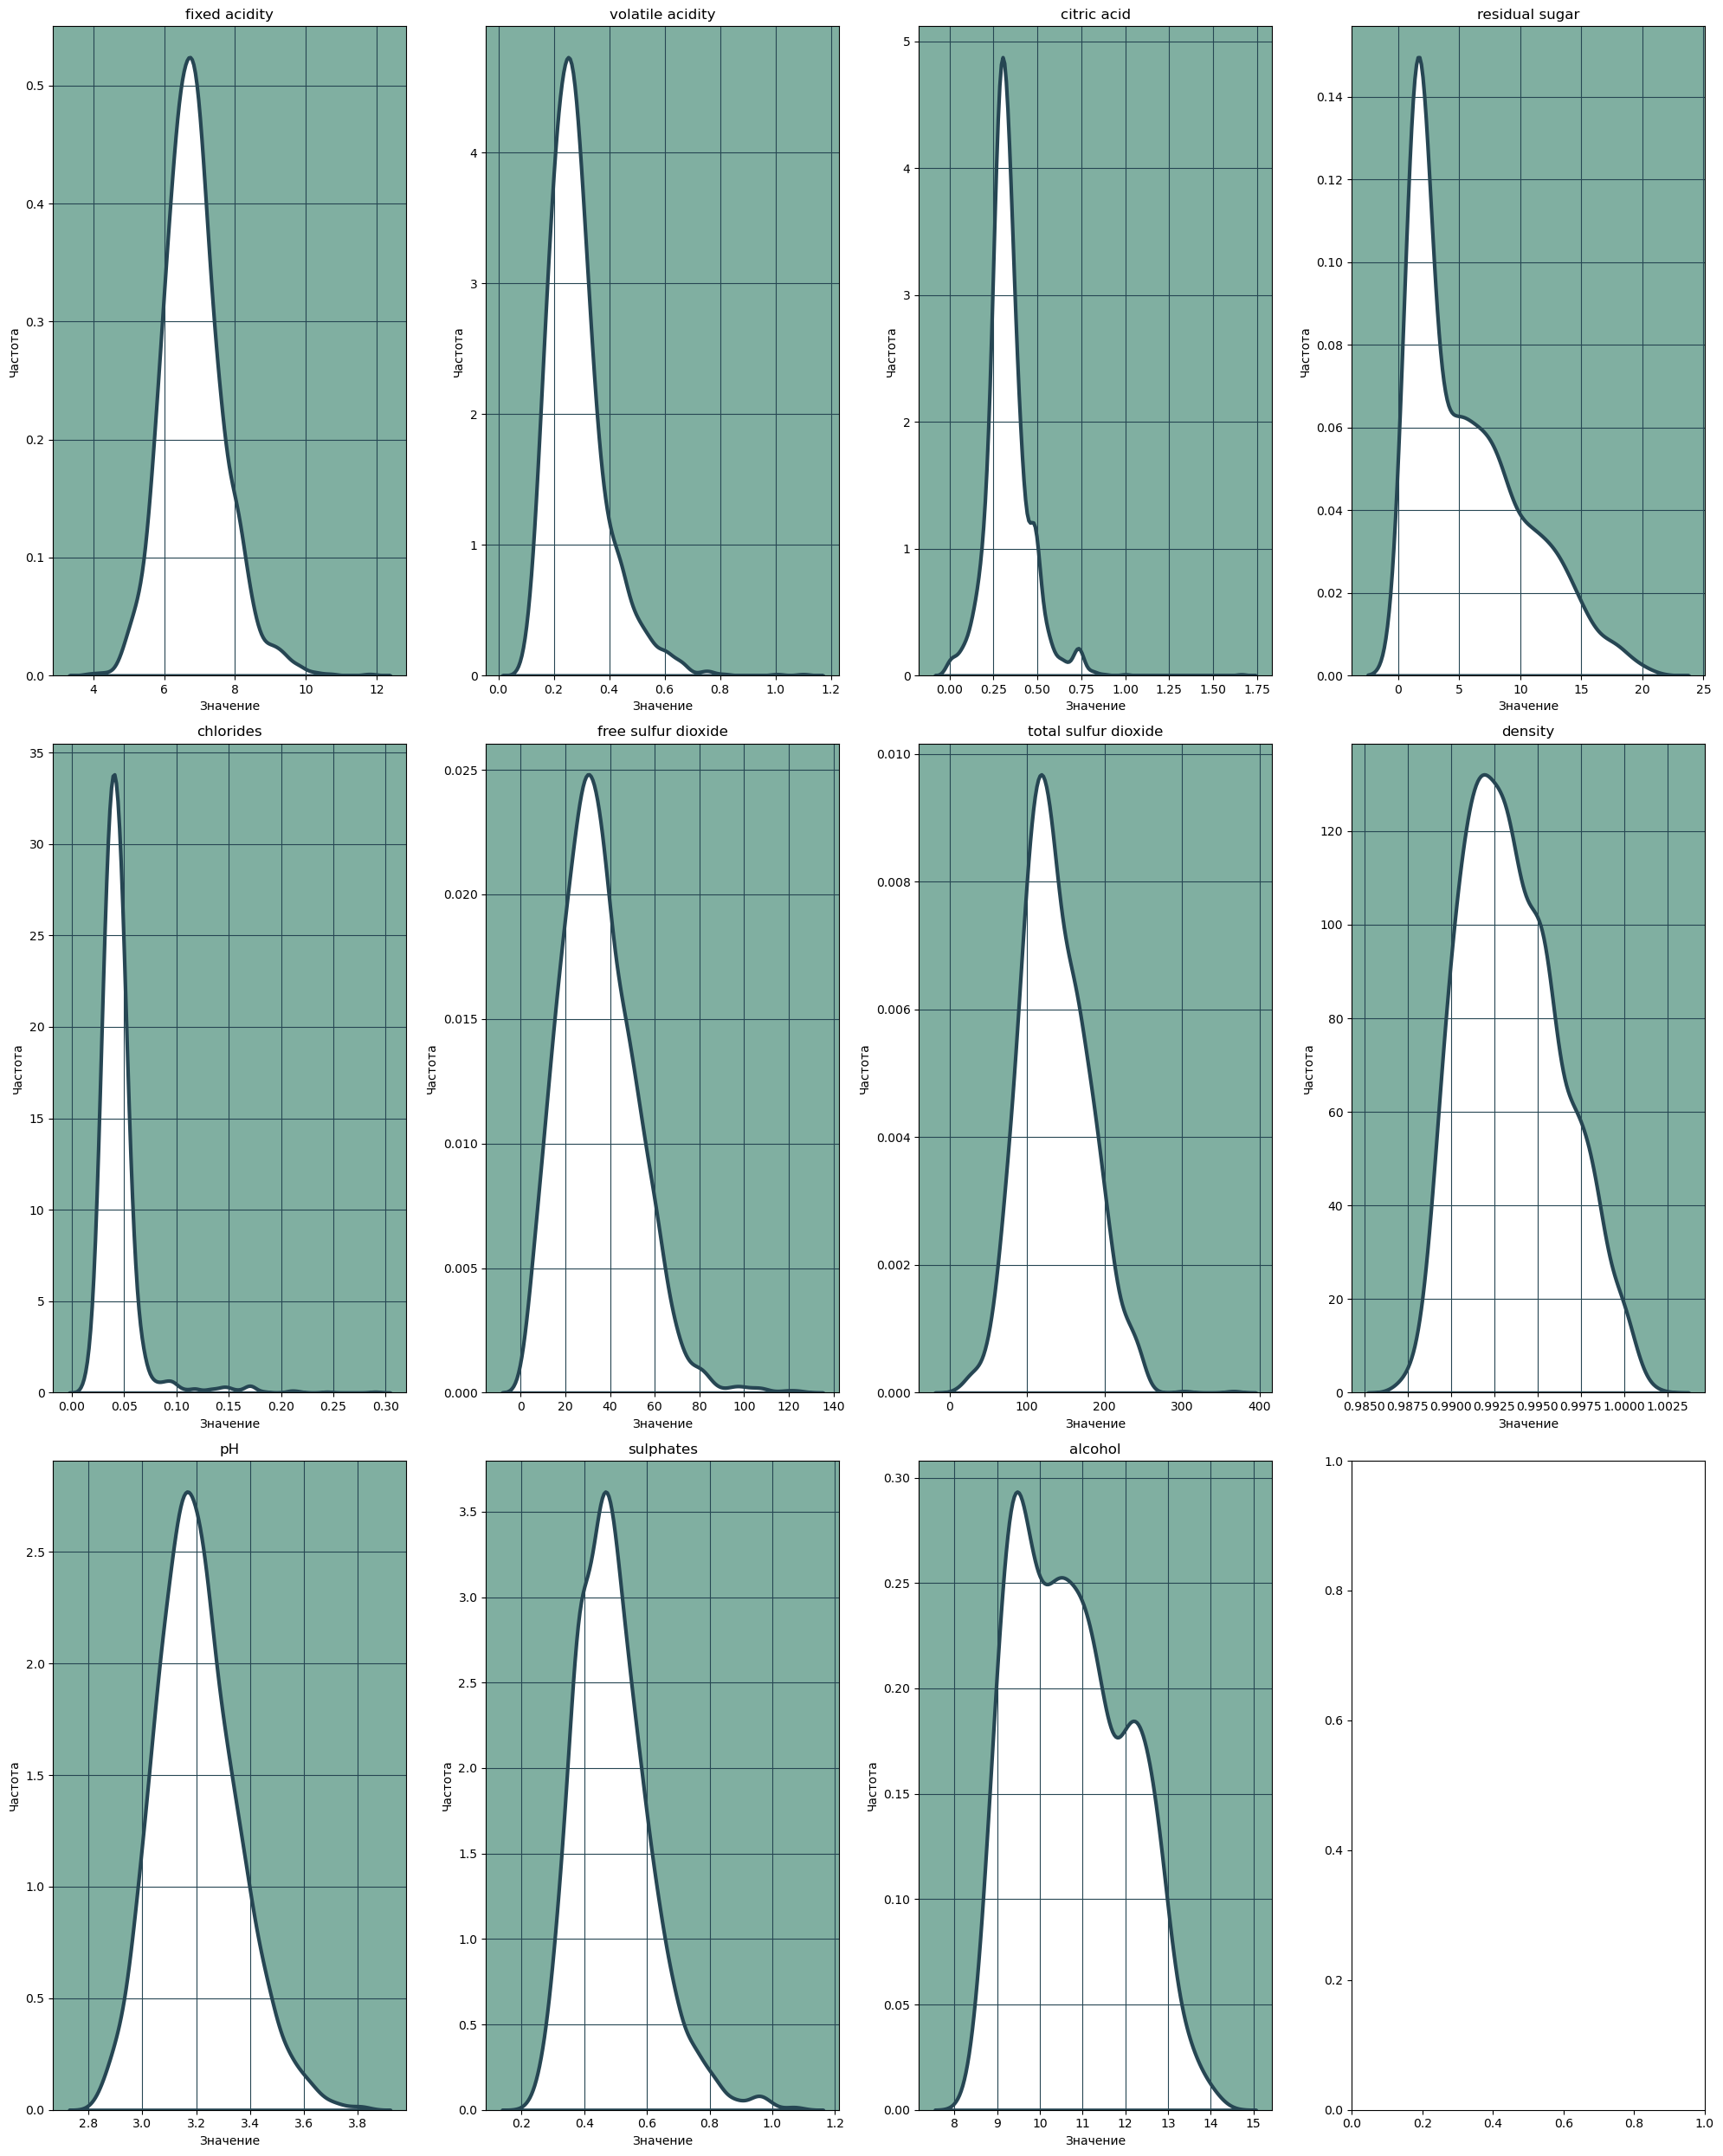

In [11]:
def plot_distributions(df):
    
    num_columns = df.shape[1]
    num_plots_per_row = 4
    num_rows = (num_columns + num_plots_per_row - 1) // num_plots_per_row
    
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    num_cols_per_row = 4
    num_num_rows = (len(numerical_cols) + num_cols_per_row - 1) // num_cols_per_row
    
    cat_cols_per_row = 3
    num_cat_rows = (len(categorical_cols) + cat_cols_per_row - 1) // cat_cols_per_row
    
    fig, axes = plt.subplots(num_num_rows + num_cat_rows, max(num_cols_per_row, cat_cols_per_row), figsize=(20, 25))
    fig.set_facecolor("#fff")
    
    # Numerical column 
    n_num_feat = 0
    for row in range(num_num_rows):
        for col in range(num_cols_per_row):
            if n_num_feat < len(numerical_cols):
                sns.kdeplot(x=numerical_cols[n_num_feat], fill=True, alpha=1, linewidth=3,
                                edgecolor="#264653", data=df, ax=axes[row, col], color="w")
                axes[row, col].patch.set_facecolor("#619b8a")
                axes[row, col].patch.set_alpha(0.8)
                axes[row, col].grid(color="#264653", alpha=1, axis="both")
                axes[row, col].set_title(numerical_cols[n_num_feat])
                axes[row, col].set_xlabel('Значение')
                axes[row, col].set_ylabel('Частота')
                
                n_num_feat += 1
    
    # Categorical column 
    n_cat_feat = 0
    for row in range(num_num_rows, num_num_rows + num_cat_rows):
        for col in range(cat_cols_per_row):
            if n_cat_feat < len(categorical_cols):
                sns.countplot(x=categorical_cols[n_cat_feat], data=df, ax=axes[row, col])
                
                axes[row, col].patch.set_facecolor("#619b8a")
                axes[row, col].patch.set_alpha(0.8)
                axes[row, col].grid(color="#264653", alpha=1, axis="both")
                axes[row, col].set_title(categorical_cols[n_cat_feat])
                axes[row, col].set_xlabel('Категория')
                axes[row, col].set_ylabel('Количество')
                
                n_cat_feat += 1
    if num_columns % num_plots_per_row != 0:
        for j in range(num_columns % num_plots_per_row, num_plots_per_row):
            axes[row, j].axis('off')
    
    plt.tight_layout()
    plt.show()
plot_distributions(df)

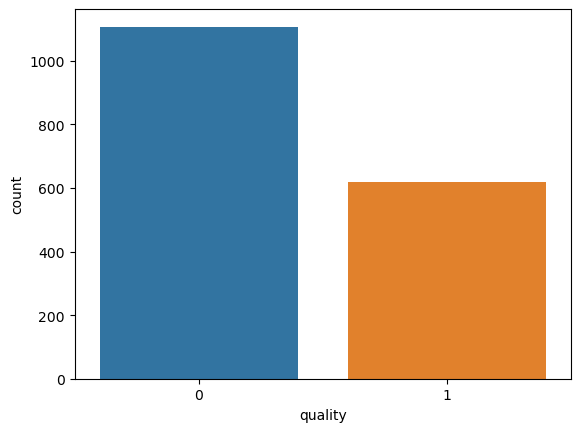

In [12]:
sns.countplot(x=df['quality']);

Классы не сбалансированы -> используем стратификацию, accuracy точно не подойдет как метрика. ROC_AUС как устойчивый к дизбалансным классам подходойдет лучше

Предпосылки: 

Основная метрика: roc_aug, покажет качество разделения на классы, устойчив к имбалансности, неплохая метрика в условиях малой информации  о бизнес задаче

при покупке вина, мы хотим быть уверены что определелим максимальное количество хороших вин. По этой причине precision<recall
                                                                                                                           
Однако все обстоит иначе с точки зрения продавца, ведь он не хочет продать плохое вино и получить штраф, поэтому для него важнее precision
                                                                                                                              
Из-за этой двоякой ситуации вторичной метрикой будет f1 как усредненный вариант в условиях неопределенности                                                                                                                                                                                                                                             

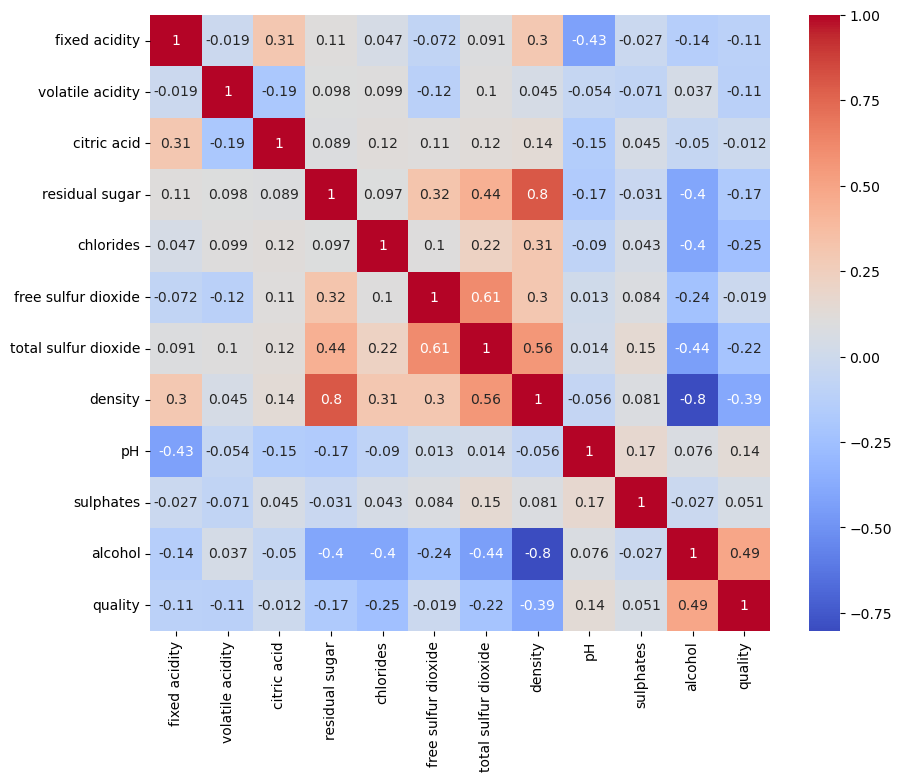

In [13]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

 есть большая корреляция между density-sugar и отрицательная между density-alcohol -> посмотрим как изменятся метрики с и без столбца density

Для начала посмотрим обучение на всех данных 

In [14]:
y = df.quality
X = df.drop(columns =['quality'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y, random_state=42)

pipe_1 = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('regressor', KNeighborsClassifier())])

strat = StratifiedShuffleSplit(n_splits=5, test_size = 0.3, train_size = 0.6, random_state = 42)

p = [1,2]
weights = ['uniform','distance']
n_neighbors = np.arange(2,60)
scaling = [ MinMaxScaler(), StandardScaler(),RobustScaler(),Normalizer()]


param_grid =[
    {'preprocessing': scaling, 
     'regressor': [KNeighborsClassifier()],
         'regressor__n_neighbors': n_neighbors,
         'regressor__p': p,
         'regressor__weights': weights
     }]

grid_1 = GridSearchCV(pipe_1, param_grid, scoring='roc_auc' ,cv=strat,return_train_score=True)
grid_1.fit(X_train,y_train)
grid_1

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.3,
            train_size=0.6),
             estimator=Pipeline(steps=[('preprocessing', MinMaxScaler()),
                                       ('regressor', KNeighborsClassifier())]),
             param_grid=[{'preprocessing': [MinMaxScaler(), StandardScaler(),
                                            RobustScaler(), Normalizer()],
                          'regressor': [KNeighborsClassifier(n_neighbors=58,
                                                             p=1,
                                                             weights='distance')],
                          'regressor__n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59]),
                          'regressor__p':

In [15]:
print("Наилучшие параметры:\n{}\n".format(grid_1.best_params_))
print("Средняя правильность для наилучшей модели кроссвалидации на" 
      "валидационных тестовых наборах: {:.6f}\n".format(grid_1.best_score_)) 
print("Правильность для наилучшей модели на тестовом наборе: {:.6f}\n".format(grid_1.score(X_test, y_test)))
otvet1 = grid_1.score(X_test, y_test)
grid_result_1 = pd.DataFrame(grid_1.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result_1

Наилучшие параметры:
{'preprocessing': RobustScaler(), 'regressor': KNeighborsClassifier(n_neighbors=58, p=1, weights='distance'), 'regressor__n_neighbors': 58, 'regressor__p': 1, 'regressor__weights': 'distance'}

Средняя правильность для наилучшей модели кроссвалидации навалидационных тестовых наборах: 0.827283

Правильность для наилучшей модели на тестовом наборе: 0.846709



,689,693,673,685,645,665,681,669,641,653,...,712,708,701,704,702,699,697,700,698,696
mean_fit_time,0.015318,0.01097,0.012788,0.017072,0.006789,0.012691,0.015041,0.008884,0.010927,0.017061,...,0.010172,0.008976,0.009359,0.008563,0.008583,0.008613,0.008778,0.008169,0.008547,0.008579
std_fit_time,0.001961,0.002523,0.000413,0.001732,0.002221,0.000792,0.001942,0.00459,0.003301,0.0031,...,0.001935,0.000004,0.001286,0.000481,0.000489,0.000527,0.000778,0.000378,0.000552,0.00049
mean_score_time,0.031178,0.024341,0.025678,0.032398,0.013955,0.024783,0.031049,0.016041,0.01794,0.02783,...,0.013167,0.010372,0.009357,0.010002,0.009573,0.009374,0.009383,0.009418,0.008952,0.008972
std_score_time,0.001619,0.004215,0.002223,0.002234,0.002606,0.000259,0.002928,0.007553,0.005894,0.001912,...,0.001934,0.000799,0.000508,0.000056,0.000496,0.000486,0.000473,0.000471,0.000024,0.000035
param_preprocessing,RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),...,Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer()
param_regressor,"KNeighborsClassifier(n_neighbors=58, p=1, weig...","KNeighborsClassifier(n_neighbors=58, p=1, weig...","KNeighborsClassifier(n_neighbors=58, p=1, weig...","KNeighborsClassifier(n_neighbors=58, p=1, weig...","KNeighborsClassifier(n_neighbors=58, p=1, weig...","KNeighborsClassifier(n_neighbors=58, p=1, weig...","KNeighborsClassifier(n_neighbors=58, p=1, weig...","KNeighborsClassifier(n_neighbors=58, p=1, weig...","KNeighborsClassifier(n_neighbors=58, p=1, weig...","KNeighborsClassifier(n_neighbors=58, p=1, weig...",...,"KNeighborsClassifier(n_neighbors=58, p=1, weig...","KNeighborsClassifier(n_neighbors=58, p=1, weig...","KNeighborsClassifier(n_neighbors=58, p=1, weig...","KNeighborsClassifier(n_neighbors=58, p=1, weig...","KNeighborsClassifier(n_neighbors=58, p=1, weig...","KNeighborsClassifier(n_neighbors=58, p=1, weig...","KNeighborsClassifier(n_neighbors=58, p=1, weig...","KNeighborsClassifier(n_neighbors=58, p=1, weig...","KNeighborsClassifier(n_neighbors=58, p=1, weig...","KNeighborsClassifier(n_neighbors=58, p=1, weig..."
param_regressor__n_neighbors,58,59,54,57,47,52,56,53,46,49,...,6,5,3,4,3,2,2,3,2,2
param_regressor__p,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,2,2,1,1,2,1
param_regressor__weights,distance,distance,distance,distance,distance,distance,distance,distance,distance,distance,...,uniform,uniform,distance,uniform,uniform,distance,distance,uniform,uniform,uniform
params,"{'preprocessing': RobustScaler(), 'regressor':...","{'preprocessing': RobustScaler(), 'regressor':...","{'preprocessing': RobustScaler(), 'regressor':...","{'preprocessing': RobustScaler(), 'regressor':...","{'preprocessing': RobustScaler(), 'regressor':...","{'preprocessing': RobustScaler(), 'regressor':...","{'preprocessing': RobustScaler(), 'regressor':...","{'preprocessing': RobustScaler(), 'regressor':...","{'preprocessing': RobustScaler(), 'regressor':...","{'preprocessing': RobustScaler(), 'regressor':...",...,"{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K..."


D:\bebeprogram\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot:>

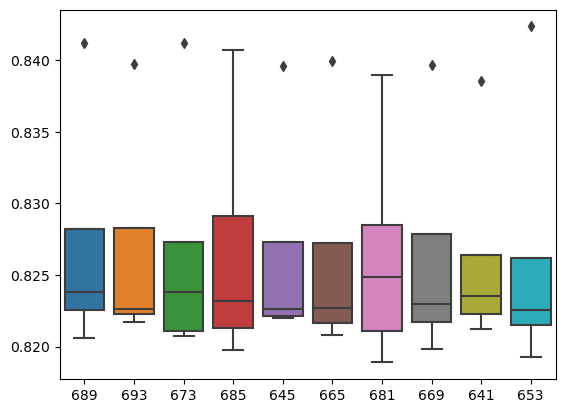

In [16]:
mask = grid_result_1.index[grid_result_1.index.str.endswith("_test_score")][:-3]
tabl = grid_result_1.loc[mask].iloc[:,:10]
sns.boxplot(data=tabl)

In [17]:
best_model_1 = grid_1.best_estimator_
print(classification_report(y_test, best_model_1.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       332
           1       0.69      0.70      0.70       186

    accuracy                           0.78       518
   macro avg       0.76      0.76      0.76       518
weighted avg       0.78      0.78      0.78       518



In [18]:
pipe_2 = Pipeline([
    ('preprocessing', MinMaxScaler()),
    ('clf', LogisticRegression())
])

strat = StratifiedShuffleSplit(test_size=0.3, train_size=0.6, n_splits=5, random_state=42)
scaling = [MinMaxScaler(), StandardScaler(), RobustScaler(), Normalizer()]
param_grid = [
    {'preprocessing': scaling, 'clf__penalty': ['l2'], 'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'clf__C': [0.1, 0.5, 1.5, 3.0], 'clf__max_iter': [100, 300, 800]},
    {'preprocessing': scaling, 'clf__penalty': ['l1'], 'clf__solver': ['liblinear'], 'clf__C': [0.1, 0.5, 1.5, 3.0], 'clf__max_iter': [100, 300, 800]},
    {'preprocessing': scaling, 'clf__penalty': ['none'], 'clf__solver': ['lbfgs', 'newton-cg'], 'clf__max_iter': [100, 300, 800]}
]

grid_2 = GridSearchCV(pipe_2, param_grid, cv=strat, scoring='roc_auc', return_train_score=True)
grid_2.fit(X_train, y_train)
grid_result_2 = pd.DataFrame(grid_2.cv_results_).sort_values(["rank_test_score", 'std_test_score']).T
grid_result_2

D:\bebeprogram\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\bebeprogram\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\bebeprogram\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\bebeprogram\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\bebeprogram\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\bebeprogram\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warning

D:\bebeprogram\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\bebeprogram\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\bebeprogram\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\bebeprogram\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\bebeprogram\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\bebeprogram\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warning

,290,292,293,294,298,300,301,302,306,308,...,55,7,27,47,11,31,51,243,247,251
mean_fit_time,0.022939,0.036203,0.029512,0.033605,0.024155,0.034028,0.026923,0.034545,0.023139,0.034108,...,0.011181,0.015058,0.014761,0.014229,0.007178,0.006988,0.007532,0.007188,0.00738,0.007585
std_fit_time,0.001784,0.003443,0.001337,0.003041,0.001615,0.003378,0.001093,0.002102,0.000745,0.002311,...,0.000396,0.001343,0.000746,0.00037,0.000375,0.000632,0.000549,0.000772,0.000822,0.000493
mean_score_time,0.005385,0.005055,0.005586,0.004969,0.004657,0.005116,0.005188,0.005387,0.004984,0.005387,...,0.004783,0.004706,0.005785,0.004843,0.004783,0.004589,0.00458,0.004691,0.004794,0.004387
std_score_time,0.000798,0.000645,0.001016,0.00067,0.000562,0.000264,0.000398,0.00049,0.000002,0.00049,...,0.000376,0.0004,0.000398,0.000839,0.000398,0.000486,0.000483,0.000387,0.000407,0.000487
param_clf__C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
param_clf__max_iter,100,100,100,100,300,300,300,300,800,800,...,800,100,300,800,100,300,800,100,300,800
param_clf__penalty,none,none,none,none,none,none,none,none,none,none,...,l2,l2,l2,l2,l2,l2,l2,l1,l1,l1
param_clf__solver,lbfgs,newton-cg,newton-cg,newton-cg,lbfgs,newton-cg,newton-cg,newton-cg,lbfgs,newton-cg,...,sag,lbfgs,lbfgs,lbfgs,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear
param_preprocessing,RobustScaler(),MinMaxScaler(),StandardScaler(),RobustScaler(),RobustScaler(),MinMaxScaler(),StandardScaler(),RobustScaler(),RobustScaler(),MinMaxScaler(),...,Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer()
params,"{'clf__max_iter': 100, 'clf__penalty': 'none',...","{'clf__max_iter': 100, 'clf__penalty': 'none',...","{'clf__max_iter': 100, 'clf__penalty': 'none',...","{'clf__max_iter': 100, 'clf__penalty': 'none',...","{'clf__max_iter': 300, 'clf__penalty': 'none',...","{'clf__max_iter': 300, 'clf__penalty': 'none',...","{'clf__max_iter': 300, 'clf__penalty': 'none',...","{'clf__max_iter': 300, 'clf__penalty': 'none',...","{'clf__max_iter': 800, 'clf__penalty': 'none',...","{'clf__max_iter': 800, 'clf__penalty': 'none',...",...,"{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe..."


In [19]:
print("Наилучшие параметры:\n{}\n".format(grid_2.best_params_))
print("Средняя правильность для наилучшей модели кроссвалидации на" 
      "валидационных тестовых наборах: {:.6f}\n".format(grid_2.best_score_)) 
print("Правильность для наилучшей модели на тестовом наборе: {:.6f}\n".format(grid_2.score(X_test, y_test)))
otvet2 = grid_2.score(X_test, y_test)
grid_result_2 = pd.DataFrame(grid_2.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result_2

Наилучшие параметры:
{'clf__max_iter': 100, 'clf__penalty': 'none', 'clf__solver': 'lbfgs', 'preprocessing': RobustScaler()}

Средняя правильность для наилучшей модели кроссвалидации навалидационных тестовых наборах: 0.817313

Правильность для наилучшей модели на тестовом наборе: 0.831892



,290,292,293,294,298,300,301,302,306,308,...,55,7,27,47,11,31,51,243,247,251
mean_fit_time,0.022939,0.036203,0.029512,0.033605,0.024155,0.034028,0.026923,0.034545,0.023139,0.034108,...,0.011181,0.015058,0.014761,0.014229,0.007178,0.006988,0.007532,0.007188,0.00738,0.007585
std_fit_time,0.001784,0.003443,0.001337,0.003041,0.001615,0.003378,0.001093,0.002102,0.000745,0.002311,...,0.000396,0.001343,0.000746,0.00037,0.000375,0.000632,0.000549,0.000772,0.000822,0.000493
mean_score_time,0.005385,0.005055,0.005586,0.004969,0.004657,0.005116,0.005188,0.005387,0.004984,0.005387,...,0.004783,0.004706,0.005785,0.004843,0.004783,0.004589,0.00458,0.004691,0.004794,0.004387
std_score_time,0.000798,0.000645,0.001016,0.00067,0.000562,0.000264,0.000398,0.00049,0.000002,0.00049,...,0.000376,0.0004,0.000398,0.000839,0.000398,0.000486,0.000483,0.000387,0.000407,0.000487
param_clf__C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
param_clf__max_iter,100,100,100,100,300,300,300,300,800,800,...,800,100,300,800,100,300,800,100,300,800
param_clf__penalty,none,none,none,none,none,none,none,none,none,none,...,l2,l2,l2,l2,l2,l2,l2,l1,l1,l1
param_clf__solver,lbfgs,newton-cg,newton-cg,newton-cg,lbfgs,newton-cg,newton-cg,newton-cg,lbfgs,newton-cg,...,sag,lbfgs,lbfgs,lbfgs,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear
param_preprocessing,RobustScaler(),MinMaxScaler(),StandardScaler(),RobustScaler(),RobustScaler(),MinMaxScaler(),StandardScaler(),RobustScaler(),RobustScaler(),MinMaxScaler(),...,Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer()
params,"{'clf__max_iter': 100, 'clf__penalty': 'none',...","{'clf__max_iter': 100, 'clf__penalty': 'none',...","{'clf__max_iter': 100, 'clf__penalty': 'none',...","{'clf__max_iter': 100, 'clf__penalty': 'none',...","{'clf__max_iter': 300, 'clf__penalty': 'none',...","{'clf__max_iter': 300, 'clf__penalty': 'none',...","{'clf__max_iter': 300, 'clf__penalty': 'none',...","{'clf__max_iter': 300, 'clf__penalty': 'none',...","{'clf__max_iter': 800, 'clf__penalty': 'none',...","{'clf__max_iter': 800, 'clf__penalty': 'none',...",...,"{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe..."


D:\bebeprogram\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot:>

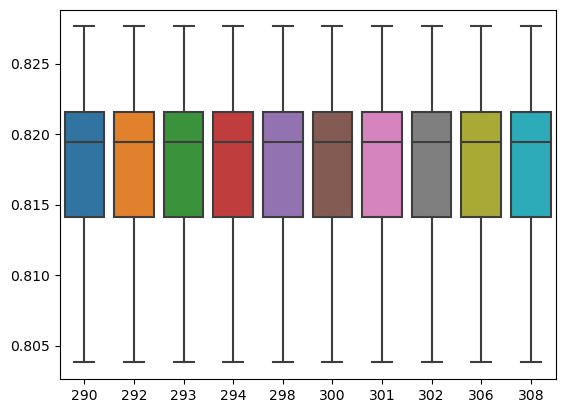

In [20]:
mask = grid_result_2.index[grid_result_2.index.str.endswith("_test_score")][:-3]
tabl = grid_result_2.loc[mask].iloc[:,:10]
sns.boxplot(data=tabl)

In [21]:
best_model_2 = grid_2.best_estimator_
print(classification_report(y_test, best_model_2.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81       332
           1       0.67      0.64      0.66       186

    accuracy                           0.76       518
   macro avg       0.74      0.73      0.73       518
weighted avg       0.76      0.76      0.76       518



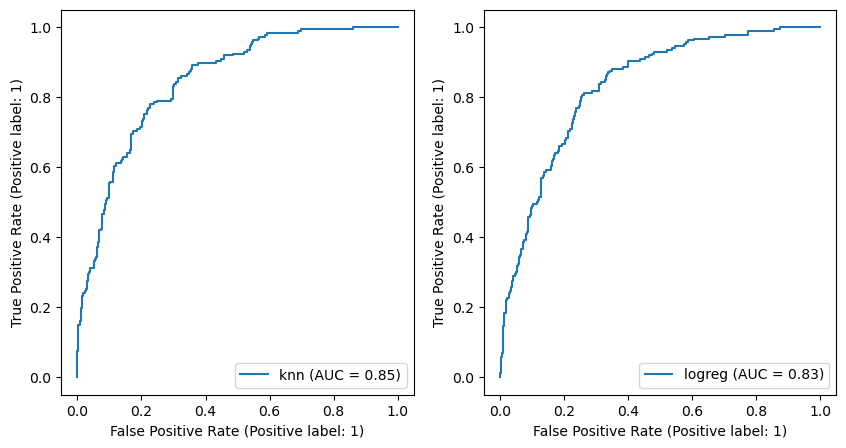

In [22]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
RocCurveDisplay.from_estimator(best_model_1, X_test, y_test, ax = ax, name = 'knn');
ax = plt.subplot(1, 2, 2)
RocCurveDisplay.from_estimator(best_model_2, X_test, y_test, ax = ax, name = 'logreg');

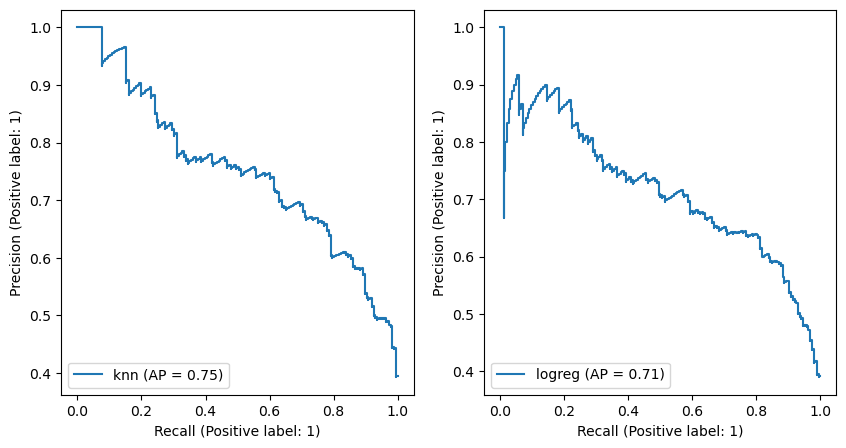

In [23]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
PrecisionRecallDisplay.from_estimator(best_model_1, X_test, y_test, ax = ax, name = 'knn');
ax = plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_estimator(best_model_2, X_test, y_test, ax = ax, name = 'logreg');

In [24]:
best_model_1 = grid_1.best_estimator_
print(classification_report(y_test, best_model_1.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       332
           1       0.69      0.70      0.70       186

    accuracy                           0.78       518
   macro avg       0.76      0.76      0.76       518
weighted avg       0.78      0.78      0.78       518



In [25]:
y_pred_1 = np.where(best_model_1.predict_proba(X_test)[:,1]>=0.50, 1, 0)
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       332
           1       0.69      0.70      0.70       186

    accuracy                           0.78       518
   macro avg       0.76      0.76      0.76       518
weighted avg       0.78      0.78      0.78       518



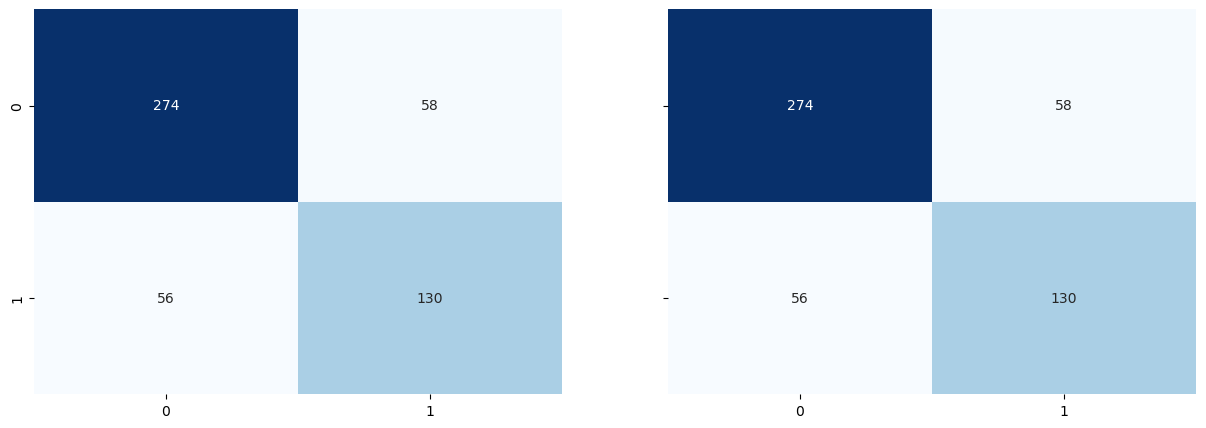

In [26]:
matrix_1=confusion_matrix(y_test,best_model_1.predict(X_test))
matrix_2=confusion_matrix(y_test,y_pred_1)
fig,ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,5))
ax = plt.subplot(1, 2, 1)
sns.heatmap(matrix_1,annot=True, fmt='g', cbar=None,cmap="Blues");
ax = plt.subplot(1, 2, 2)
sns.heatmap(matrix_2,annot=True, fmt='g', cbar=None,cmap="Blues");

In [27]:
y_pred_2 = np.where(best_model_2.predict_proba(X_test)[:,1]>=0.34, 1, 0)
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.89      0.68      0.77       332
           1       0.60      0.84      0.70       186

    accuracy                           0.74       518
   macro avg       0.74      0.76      0.73       518
weighted avg       0.78      0.74      0.74       518



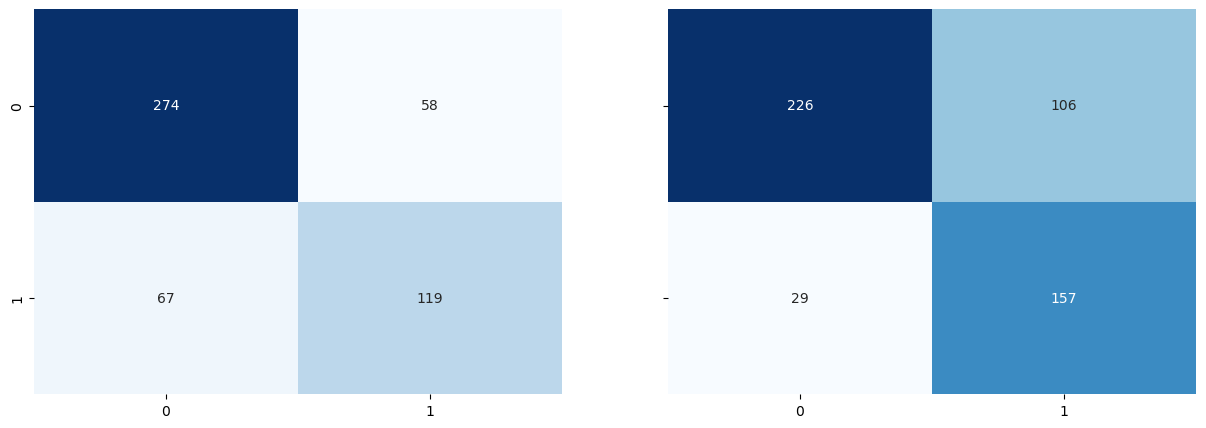

In [28]:
matrix_1=confusion_matrix(y_test,best_model_2.predict(X_test))
matrix_2=confusion_matrix(y_test,y_pred_2)
fig,ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,5))
ax = plt.subplot(1, 2, 1)
sns.heatmap(matrix_1,annot=True, fmt='g', cbar=None,cmap="Blues");
ax = plt.subplot(1, 2, 2)
sns.heatmap(matrix_2,annot=True, fmt='g', cbar=None,cmap="Blues");

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(solver='newton-cg'))])


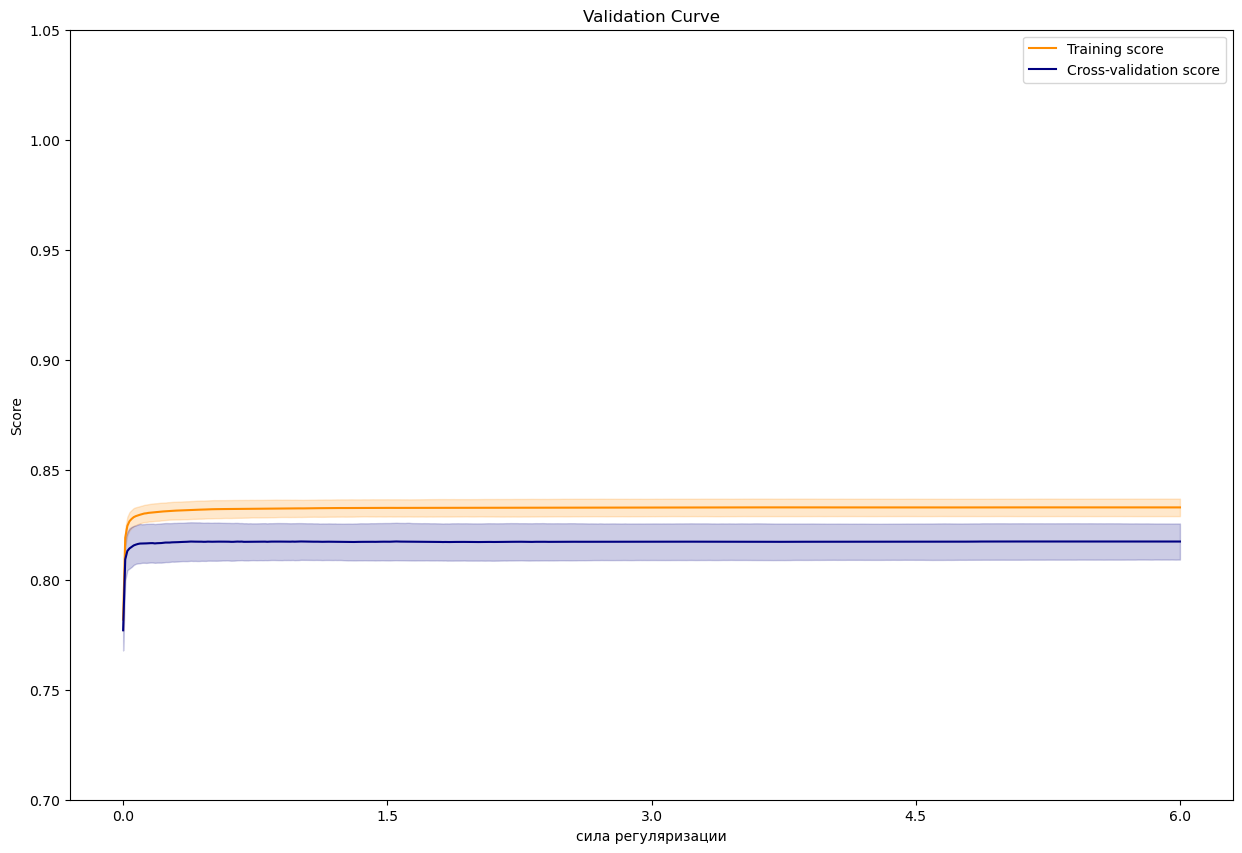

In [29]:
pipe_fin = make_pipeline( StandardScaler(), LogisticRegression(solver = 'newton-cg', penalty = 'l2'))
print(pipe_fin)

n_range = np.linspace(0.0001, 6, 500)
train_scores, test_scores = validation_curve(
    pipe_fin , X_train, y_train,
    param_name = "logisticregression__C", 
    param_range = n_range,
    cv = StratifiedShuffleSplit(n_splits=5, test_size = 0.3, train_size = 0.6, random_state = 42), 
    scoring="roc_auc", 
    n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(15,10))

plt.title("Validation Curve")
plt.xlabel("сила регуляризации")
plt.ylabel("Score")
plt.ylim(0.7, 1.05)

plt.plot(n_range, train_scores_mean, label="Training score", color="darkorange")
plt.fill_between(n_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange")
plt.plot(n_range, test_scores_mean, label="Cross-validation score",
             color="navy")
plt.fill_between(n_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy")

plt.xticks(np.linspace(0, 6, 5))
plt.legend(loc="best")
plt.show()


Если график не врет, то параметр регуляризации не влияет на предсказание
Поэтому добавил в сетку регрессии пару значений С исключительно для чистоты совести

In [30]:
pipe_3 = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('clf',           GaussianNB())])

cv = StratifiedShuffleSplit(test_size = .3, train_size = .6, n_splits = 5, random_state = 42)
scaling = [ MinMaxScaler(), StandardScaler(),RobustScaler(), Normalizer()]

param_grid =[
    {'preprocessing': scaling, 
     'clf': [GaussianNB()]}
    ]

grid_3 = GridSearchCV(pipe_3, param_grid, cv = cv, scoring='roc_auc',return_train_score = True)
grid_3.fit(X_train, y_train)
grid_3


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.3,
            train_size=0.6),
             estimator=Pipeline(steps=[('preprocessing', MinMaxScaler()),
                                       ('clf', GaussianNB())]),
             param_grid=[{'clf': [GaussianNB()],
                          'preprocessing': [MinMaxScaler(), StandardScaler(),
                                            RobustScaler(), Normalizer()]}],
             return_train_score=True, scoring='roc_auc')

In [31]:
print("Наилучшие параметры:\n{}\n".format(grid_3.best_params_))
print("Средняя правильность для наилучшей модели кроссвалидации на" 
      "валидационных тестовых наборах: {:.6f}\n".format(grid_3.best_score_)) 
print("Правильность для наилучшей модели на тестовом наборе: {:.6f}\n".format(grid_3.score(X_test, y_test)))
otvet3 = grid_3.score(X_test, y_test)
grid_result_3 = pd.DataFrame(grid_3.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result_3

Наилучшие параметры:
{'clf': GaussianNB(), 'preprocessing': MinMaxScaler()}

Средняя правильность для наилучшей модели кроссвалидации навалидационных тестовых наборах: 0.794341

Правильность для наилучшей модели на тестовом наборе: 0.819115



,0,1,2,3
mean_fit_time,0.010772,0.00837,0.011161,0.006721
std_fit_time,0.002393,0.001004,0.000405,0.000387
mean_score_time,0.006712,0.005026,0.005201,0.005395
std_score_time,0.001327,0.000604,0.000986,0.000492
param_clf,GaussianNB(),GaussianNB(),GaussianNB(),GaussianNB()
param_preprocessing,MinMaxScaler(),StandardScaler(),RobustScaler(),Normalizer()
params,"{'clf': GaussianNB(), 'preprocessing': MinMaxS...","{'clf': GaussianNB(), 'preprocessing': Standar...","{'clf': GaussianNB(), 'preprocessing': RobustS...","{'clf': GaussianNB(), 'preprocessing': Normali..."
split0_test_score,0.793892,0.793892,0.793892,0.676065
split1_test_score,0.789402,0.789402,0.789402,0.708485
split2_test_score,0.778409,0.778409,0.778409,0.678376


D:\bebeprogram\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot:>

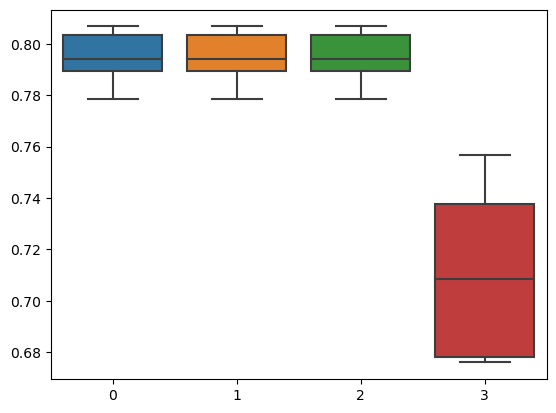

In [32]:
mask = grid_result_3.index[grid_result_3.index.str.endswith("_test_score")][:-3]
tabl = grid_result_3.loc[mask].iloc[:,:10]
sns.boxplot(data=tabl)

In [33]:
best_model_3 = grid_3.best_estimator_
print(classification_report(y_test, best_model_3.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.66      0.75       332
           1       0.58      0.84      0.69       186

    accuracy                           0.72       518
   macro avg       0.73      0.75      0.72       518
weighted avg       0.77      0.72      0.73       518



In [34]:
y_pred_3 = np.where(best_model_3.predict_proba(X_test)[:,1]>=0.37, 1, 0)
print(classification_report(y_test, y_pred_3))

              precision    recall  f1-score   support

           0       0.89      0.62      0.73       332
           1       0.56      0.86      0.68       186

    accuracy                           0.70       518
   macro avg       0.72      0.74      0.70       518
weighted avg       0.77      0.70      0.71       518



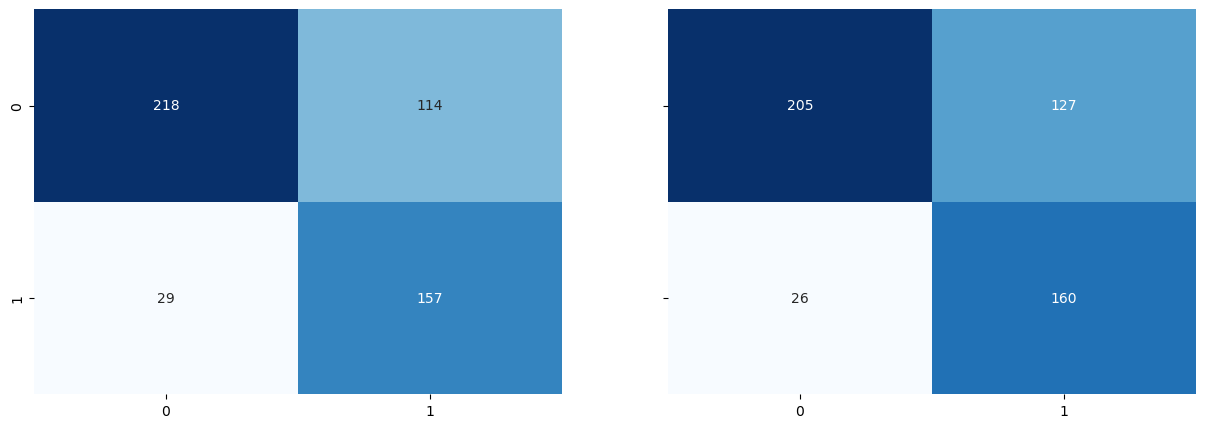

In [35]:
matrix_1=confusion_matrix(y_test,best_model_3.predict(X_test))
matrix_2=confusion_matrix(y_test,y_pred_3)
fig,ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,5))
ax = plt.subplot(1, 2, 1)
sns.heatmap(matrix_1,annot=True, fmt='g', cbar=None,cmap="Blues");
ax = plt.subplot(1, 2, 2)
sns.heatmap(matrix_2,annot=True, fmt='g', cbar=None,cmap="Blues");

Промежуточные выводы: knn имеет больший скор на auc_roc, но в итоговую модель скорее всего пойдет логистическая регрессия, которая имеет скор на 1% меньше, но имеет в разы меньшее среднее квадратичное отклонение и намного больший f1 score

Теперь смотрим без столбца с проклятием корреляции

In [36]:
df = df.drop(columns = 'density')
y = df.quality
X = df.drop(columns =['quality'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y, random_state=42)

pipe_4 = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('regressor', KNeighborsClassifier())])

strat = StratifiedShuffleSplit(n_splits=5, test_size = 0.3, train_size = 0.6, random_state = 42)


p = [1,2]
weights = ['uniform','distance']
n_neighbors = np.arange(2,60)
scaling = [ MinMaxScaler(), StandardScaler(),RobustScaler(),Normalizer()]

param_grid =[
    {'preprocessing': scaling, 
     'regressor': [KNeighborsClassifier()],
         'regressor__n_neighbors': n_neighbors,
         'regressor__p': p,
         'regressor__weights': weights
     }]

grid_4 = GridSearchCV(pipe_4, param_grid, scoring='roc_auc' ,cv=strat,return_train_score=True)
grid_4.fit(X_train,y_train)
grid_4

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.3,
            train_size=0.6),
             estimator=Pipeline(steps=[('preprocessing', MinMaxScaler()),
                                       ('regressor', KNeighborsClassifier())]),
             param_grid=[{'preprocessing': [MinMaxScaler(), StandardScaler(),
                                            RobustScaler(), Normalizer()],
                          'regressor': [KNeighborsClassifier(n_neighbors=51,
                                                             p=1,
                                                             weights='distance')],
                          'regressor__n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59]),
                          'regressor__p':

In [37]:
print("Наилучшие параметры:\n{}\n".format(grid_4.best_params_))
print("Средняя правильность для наилучшей модели кроссвалидации на" 
      "валидационных тестовых наборах: {:.6f}\n".format(grid_4.best_score_)) 
print("Правильность для наилучшей модели на тестовом наборе: {:.6f}\n".format(grid_4.score(X_test, y_test)))
otvet4 = grid_4.score(X_test, y_test)
grid_result_4 = pd.DataFrame(grid_4.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result_4

Наилучшие параметры:
{'preprocessing': RobustScaler(), 'regressor': KNeighborsClassifier(n_neighbors=51, p=1, weights='distance'), 'regressor__n_neighbors': 51, 'regressor__p': 1, 'regressor__weights': 'distance'}

Средняя правильность для наилучшей модели кроссвалидации навалидационных тестовых наборах: 0.827560

Правильность для наилучшей модели на тестовом наборе: 0.845414



,661,665,669,685,657,637,673,681,633,653,...,703,708,701,704,702,699,700,697,698,696
mean_fit_time,0.012544,0.01135,0.01196,0.012949,0.012654,0.012167,0.012407,0.012181,0.011989,0.012755,...,0.008567,0.00886,0.008469,0.008788,0.008568,0.008589,0.008981,0.008699,0.00819,0.008378
std_fit_time,0.001181,0.001345,0.00065,0.00065,0.000567,0.000374,0.000462,0.00037,0.00004,0.000369,...,0.000482,0.000467,0.00066,0.000407,0.000498,0.000475,0.000652,0.00064,0.000415,0.000492
mean_score_time,0.02492,0.022377,0.024523,0.024997,0.02406,0.023344,0.024889,0.025724,0.023519,0.024546,...,0.00959,0.009722,0.009197,0.009176,0.009193,0.008973,0.009383,0.008927,0.008951,0.008564
std_score_time,0.000648,0.003269,0.000524,0.00009,0.000463,0.001029,0.000081,0.000754,0.000472,0.000794,...,0.001361,0.000793,0.000483,0.0004,0.000391,0.00063,0.000505,0.000717,0.000025,0.000478
param_preprocessing,RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),...,Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer()
param_regressor,"KNeighborsClassifier(n_neighbors=51, p=1, weig...","KNeighborsClassifier(n_neighbors=51, p=1, weig...","KNeighborsClassifier(n_neighbors=51, p=1, weig...","KNeighborsClassifier(n_neighbors=51, p=1, weig...","KNeighborsClassifier(n_neighbors=51, p=1, weig...","KNeighborsClassifier(n_neighbors=51, p=1, weig...","KNeighborsClassifier(n_neighbors=51, p=1, weig...","KNeighborsClassifier(n_neighbors=51, p=1, weig...","KNeighborsClassifier(n_neighbors=51, p=1, weig...","KNeighborsClassifier(n_neighbors=51, p=1, weig...",...,"KNeighborsClassifier(n_neighbors=51, p=1, weig...","KNeighborsClassifier(n_neighbors=51, p=1, weig...","KNeighborsClassifier(n_neighbors=51, p=1, weig...","KNeighborsClassifier(n_neighbors=51, p=1, weig...","KNeighborsClassifier(n_neighbors=51, p=1, weig...","KNeighborsClassifier(n_neighbors=51, p=1, weig...","KNeighborsClassifier(n_neighbors=51, p=1, weig...","KNeighborsClassifier(n_neighbors=51, p=1, weig...","KNeighborsClassifier(n_neighbors=51, p=1, weig...","KNeighborsClassifier(n_neighbors=51, p=1, weig..."
param_regressor__n_neighbors,51,52,53,57,50,45,54,56,44,49,...,3,5,3,4,3,2,3,2,2,2
param_regressor__p,1,1,1,1,1,1,1,1,1,1,...,2,1,1,1,2,2,1,1,2,1
param_regressor__weights,distance,distance,distance,distance,distance,distance,distance,distance,distance,distance,...,distance,uniform,distance,uniform,uniform,distance,uniform,distance,uniform,uniform
params,"{'preprocessing': RobustScaler(), 'regressor':...","{'preprocessing': RobustScaler(), 'regressor':...","{'preprocessing': RobustScaler(), 'regressor':...","{'preprocessing': RobustScaler(), 'regressor':...","{'preprocessing': RobustScaler(), 'regressor':...","{'preprocessing': RobustScaler(), 'regressor':...","{'preprocessing': RobustScaler(), 'regressor':...","{'preprocessing': RobustScaler(), 'regressor':...","{'preprocessing': RobustScaler(), 'regressor':...","{'preprocessing': RobustScaler(), 'regressor':...",...,"{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K..."


D:\bebeprogram\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot:>

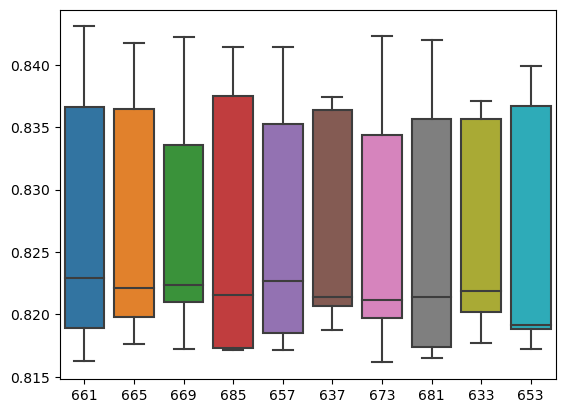

In [38]:
mask = grid_result_4.index[grid_result_4.index.str.endswith("_test_score")][:-3]
tabl = grid_result_4.loc[mask].iloc[:,:10]
sns.boxplot(data=tabl)

In [39]:
best_model_4 = grid_4.best_estimator_
print(classification_report(y_test, best_model_4.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       332
           1       0.68      0.70      0.69       186

    accuracy                           0.77       518
   macro avg       0.75      0.76      0.75       518
weighted avg       0.77      0.77      0.77       518



In [40]:
y_pred_4 = np.where(best_model_4.predict_proba(X_test)[:,1]>=0.46, 1, 0)
print(classification_report(y_test, y_pred_4))

              precision    recall  f1-score   support

           0       0.87      0.74      0.80       332
           1       0.63      0.80      0.70       186

    accuracy                           0.76       518
   macro avg       0.75      0.77      0.75       518
weighted avg       0.78      0.76      0.76       518



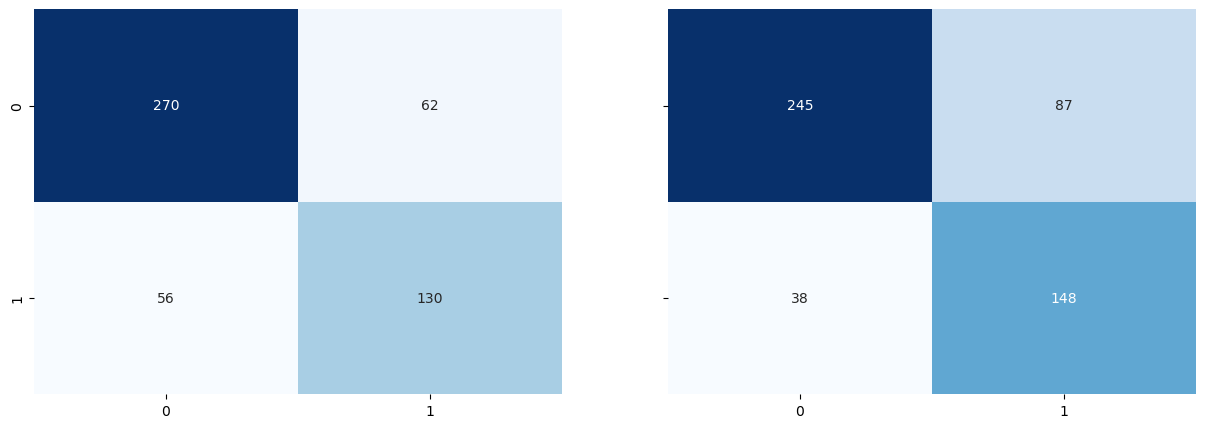

In [41]:
matrix_1=confusion_matrix(y_test,best_model_4.predict(X_test))
matrix_2=confusion_matrix(y_test,y_pred_4)
fig,ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,5))
ax = plt.subplot(1, 2, 1)
sns.heatmap(matrix_1,annot=True, fmt='g', cbar=None,cmap="Blues");
ax = plt.subplot(1, 2, 2)
sns.heatmap(matrix_2,annot=True, fmt='g', cbar=None,cmap="Blues");

In [42]:
pipe_5 = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('clf',           LogisticRegression())])

strat = StratifiedShuffleSplit(test_size = .3, train_size = .6, n_splits = 5, random_state = 42)
scaling = [ MinMaxScaler(), StandardScaler(),RobustScaler(), Normalizer()]

param_grid =[
    {'preprocessing': scaling,'clf__penalty': ['l2'], 
         'clf__solver': ['newton-cg' ,'lbfgs', 'liblinear', 'sag', 'saga'], 
     'clf__C': [0.1, 0.5, 1.5, 3.0], 'clf__max_iter': [100, 300, 800]},
    {'preprocessing': scaling,'clf__penalty': ['l1'], 
         'clf__solver': ['liblinear'], 'clf__C': [0.1, 0.5, 1.5, 3.0], 'clf__max_iter': [100, 300, 800]},
    {'preprocessing': scaling,'clf__penalty': ['none'], 
         'clf__solver': ['lbfgs','newton-cg'], 'clf__max_iter': [100, 300, 800]}
    ]

grid_5 = GridSearchCV(pipe_5, param_grid, cv = strat, scoring='roc_auc', return_train_score = True)
grid_5.fit(X_train, y_train)   
grid_result_5 = pd.DataFrame(grid_5.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result_5

D:\bebeprogram\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\bebeprogram\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\bebeprogram\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\bebeprogram\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

,17,5,13,25,45,37,53,57,1,21,...,15,23,43,55,11,31,51,243,247,251
mean_fit_time,0.012166,0.015351,0.012366,0.014759,0.014579,0.011784,0.012497,0.01156,0.024285,0.023538,...,0.01118,0.016343,0.016374,0.008906,0.007595,0.007491,0.007171,0.007362,0.007166,0.006981
std_fit_time,0.0004,0.001053,0.000797,0.000978,0.001367,0.000721,0.000771,0.000504,0.002112,0.00271,...,0.000396,0.000501,0.001599,0.001965,0.000501,0.000647,0.00038,0.00048,0.000382,0.000862
mean_score_time,0.004589,0.005178,0.004999,0.004778,0.005236,0.00458,0.004411,0.004588,0.005038,0.004961,...,0.004574,0.005408,0.004987,0.003388,0.004287,0.004618,0.004801,0.004383,0.004872,0.004322
std_score_time,0.000489,0.000737,0.000021,0.000732,0.000379,0.000486,0.000458,0.000487,0.000715,0.000593,...,0.000479,0.000506,0.000632,0.000789,0.000399,0.000453,0.000406,0.000493,0.000236,0.000415
param_clf__C,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
param_clf__max_iter,100,100,100,300,800,300,800,800,100,300,...,100,300,800,800,100,300,800,100,300,800
param_clf__penalty,l2,l2,l2,l2,l2,l2,l2,l2,l2,l2,...,l2,l2,l2,l2,l2,l2,l2,l1,l1,l1
param_clf__solver,saga,lbfgs,sag,lbfgs,lbfgs,saga,sag,saga,newton-cg,newton-cg,...,sag,newton-cg,newton-cg,sag,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear
param_preprocessing,StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),...,Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer()
params,"{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...",...,"{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe..."


In [43]:
print("Наилучшие параметры:\n{}\n".format(grid_5.best_params_))
print("Средняя правильность для наилучшей модели кроссвалидации на" 
      "валидационных тестовых наборах: {:.6f}\n".format(grid_5.best_score_)) 
print("Правильность для наилучшей модели на тестовом наборе: {:.6f}\n".format(grid_5.score(X_test, y_test)))
otvet5 = grid_5.score(X_test, y_test)
grid_result_5 = pd.DataFrame(grid_5.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result_5

Наилучшие параметры:
{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'preprocessing': StandardScaler()}

Средняя правильность для наилучшей модели кроссвалидации навалидационных тестовых наборах: 0.813807

Правильность для наилучшей модели на тестовом наборе: 0.833981



,17,5,13,25,45,37,53,57,1,21,...,15,23,43,55,11,31,51,243,247,251
mean_fit_time,0.012166,0.015351,0.012366,0.014759,0.014579,0.011784,0.012497,0.01156,0.024285,0.023538,...,0.01118,0.016343,0.016374,0.008906,0.007595,0.007491,0.007171,0.007362,0.007166,0.006981
std_fit_time,0.0004,0.001053,0.000797,0.000978,0.001367,0.000721,0.000771,0.000504,0.002112,0.00271,...,0.000396,0.000501,0.001599,0.001965,0.000501,0.000647,0.00038,0.00048,0.000382,0.000862
mean_score_time,0.004589,0.005178,0.004999,0.004778,0.005236,0.00458,0.004411,0.004588,0.005038,0.004961,...,0.004574,0.005408,0.004987,0.003388,0.004287,0.004618,0.004801,0.004383,0.004872,0.004322
std_score_time,0.000489,0.000737,0.000021,0.000732,0.000379,0.000486,0.000458,0.000487,0.000715,0.000593,...,0.000479,0.000506,0.000632,0.000789,0.000399,0.000453,0.000406,0.000493,0.000236,0.000415
param_clf__C,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
param_clf__max_iter,100,100,100,300,800,300,800,800,100,300,...,100,300,800,800,100,300,800,100,300,800
param_clf__penalty,l2,l2,l2,l2,l2,l2,l2,l2,l2,l2,...,l2,l2,l2,l2,l2,l2,l2,l1,l1,l1
param_clf__solver,saga,lbfgs,sag,lbfgs,lbfgs,saga,sag,saga,newton-cg,newton-cg,...,sag,newton-cg,newton-cg,sag,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear
param_preprocessing,StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),...,Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer()
params,"{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...",...,"{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe..."


D:\bebeprogram\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot:>

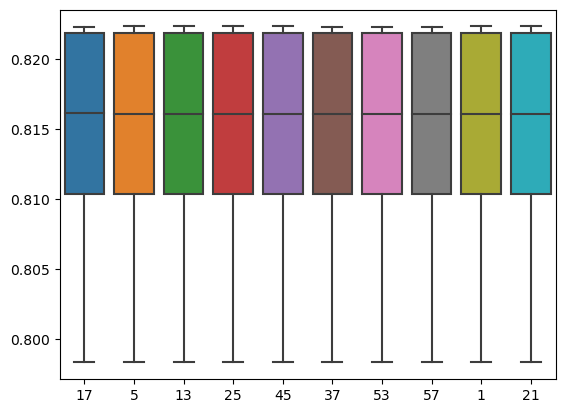

In [44]:
mask = grid_result_5.index[grid_result_5.index.str.endswith("_test_score")][:-3]
tabl = grid_result_5.loc[mask].iloc[:,:10]
sns.boxplot(data=tabl)

In [45]:
best_model_5 = grid_5.best_estimator_
print(classification_report(y_test, best_model_5.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      0.82      0.81       332
           1       0.66      0.62      0.64       186

    accuracy                           0.75       518
   macro avg       0.73      0.72      0.72       518
weighted avg       0.74      0.75      0.75       518



In [46]:
y_pred_5 = np.where(best_model_5.predict_proba(X_test)[:,1]>=0.42, 1, 0)
print(classification_report(y_test, y_pred_5))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81       332
           1       0.65      0.76      0.70       186

    accuracy                           0.76       518
   macro avg       0.75      0.76      0.75       518
weighted avg       0.78      0.76      0.77       518



In [47]:
best_model = best_model_5.named_steps['clf']
importance = best_model.coef_[0]

for i, val in enumerate(importance):
    print('Фича %d: %.5f' % (i, val))

Фича 0: 0.11926
Фича 1: -0.37572
Фича 2: -0.01816
Фича 3: 0.12107
Фича 4: -0.38386
Фича 5: 0.36210
Фича 6: -0.34117
Фича 7: 0.31902
Фича 8: 0.10731
Фича 9: 1.06265


Идея: попробовать дропнуть признаки с отрицательными коэфами важности (вдруг моедль станет умнее, как после дропа density)

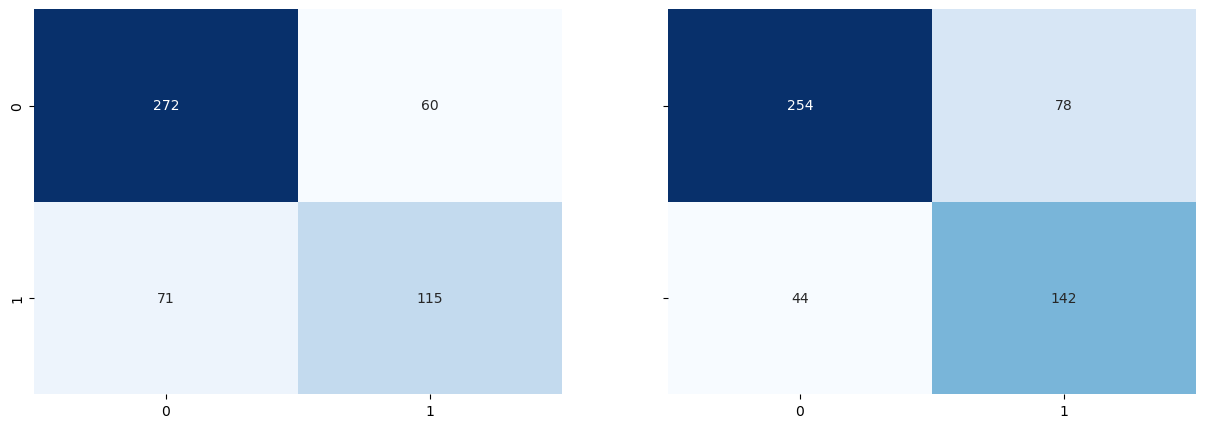

In [48]:
matrix_1=confusion_matrix(y_test,best_model_5.predict(X_test))
matrix_2=confusion_matrix(y_test,y_pred_5)
fig,ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,5))
ax = plt.subplot(1, 2, 1)
sns.heatmap(matrix_1,annot=True, fmt='g', cbar=None,cmap="Blues");
ax = plt.subplot(1, 2, 2)
sns.heatmap(matrix_2,annot=True, fmt='g', cbar=None,cmap="Blues");

In [49]:
pipe_6 = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('clf',           GaussianNB())])

cv = StratifiedShuffleSplit(test_size = .3, train_size = .6, n_splits = 5, random_state = 42)
scaling = [ MinMaxScaler(), StandardScaler(),RobustScaler(), Normalizer()]

param_grid =[
    {'preprocessing': scaling, 
     'clf': [GaussianNB()]}
    ]

grid_6 = GridSearchCV(pipe_6, param_grid, cv = cv, scoring='roc_auc', return_train_score = True)
grid_6.fit(X_train, y_train)
grid_6


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.3,
            train_size=0.6),
             estimator=Pipeline(steps=[('preprocessing', MinMaxScaler()),
                                       ('clf', GaussianNB())]),
             param_grid=[{'clf': [GaussianNB()],
                          'preprocessing': [MinMaxScaler(), StandardScaler(),
                                            RobustScaler(), Normalizer()]}],
             return_train_score=True, scoring='roc_auc')

In [50]:
print("Наилучшие параметры:\n{}\n".format(grid_6.best_params_))
print("Средняя правильность для наилучшей модели кроссвалидации на" 
      "валидационных тестовых наборах: {:.6f}\n".format(grid_6.best_score_)) 
print("Правильность для наилучшей модели на тестовом наборе: {:.6f}\n".format(grid_6.score(X_test, y_test)))
otvet6 = grid_6.score(X_test, y_test)
grid_result_6 = pd.DataFrame(grid_6.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result_6

Наилучшие параметры:
{'clf': GaussianNB(), 'preprocessing': MinMaxScaler()}

Средняя правильность для наилучшей модели кроссвалидации навалидационных тестовых наборах: 0.797676

Правильность для наилучшей модели на тестовом наборе: 0.823552



,0,1,2,3
mean_fit_time,0.007002,0.007176,0.010576,0.006546
std_fit_time,0.000647,0.000397,0.000443,0.000463
mean_score_time,0.00507,0.004983,0.00497,0.004989
std_score_time,0.00065,0.000018,0.000054,0.000005
param_clf,GaussianNB(),GaussianNB(),GaussianNB(),GaussianNB()
param_preprocessing,MinMaxScaler(),StandardScaler(),RobustScaler(),Normalizer()
params,"{'clf': GaussianNB(), 'preprocessing': MinMaxS...","{'clf': GaussianNB(), 'preprocessing': Standar...","{'clf': GaussianNB(), 'preprocessing': RobustS...","{'clf': GaussianNB(), 'preprocessing': Normali..."
split0_test_score,0.7931,0.7931,0.7931,0.680621
split1_test_score,0.790789,0.790789,0.790789,0.709508
split2_test_score,0.783196,0.783196,0.783196,0.683328


D:\bebeprogram\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot:>

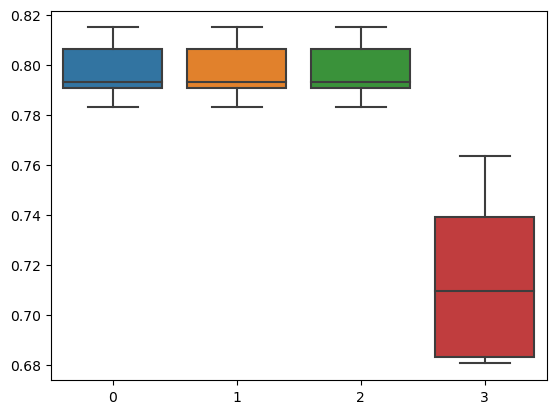

In [51]:
mask = grid_result_6.index[grid_result_6.index.str.endswith("_test_score")][:-3]
tabl = grid_result_6.loc[mask].iloc[:,:10]
sns.boxplot(data=tabl)

In [52]:
best_model_6 = grid_6.best_estimator_
print(classification_report(y_test, best_model_6.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.66      0.75       332
           1       0.57      0.82      0.68       186

    accuracy                           0.72       518
   macro avg       0.72      0.74      0.71       518
weighted avg       0.76      0.72      0.72       518



In [53]:
y_pred_6 = np.where(best_model_6.predict_proba(X_test)[:,1]>=0.61, 1, 0)
print(classification_report(y_test, y_pred_6))

              precision    recall  f1-score   support

           0       0.86      0.70      0.77       332
           1       0.60      0.79      0.68       186

    accuracy                           0.73       518
   macro avg       0.73      0.75      0.73       518
weighted avg       0.76      0.73      0.74       518



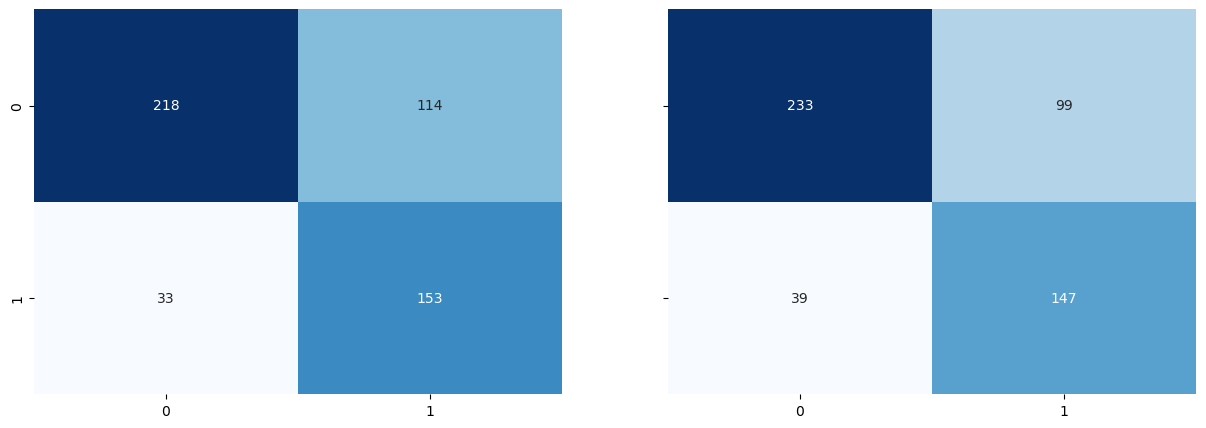

In [54]:
matrix_1=confusion_matrix(y_test,best_model_6.predict(X_test))
matrix_2=confusion_matrix(y_test,y_pred_6)
fig,ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,5))
ax = plt.subplot(1, 2, 1)
sns.heatmap(matrix_1,annot=True, fmt='g', cbar=None,cmap="Blues");
ax = plt.subplot(1, 2, 2)
sns.heatmap(matrix_2,annot=True, fmt='g', cbar=None,cmap="Blues");

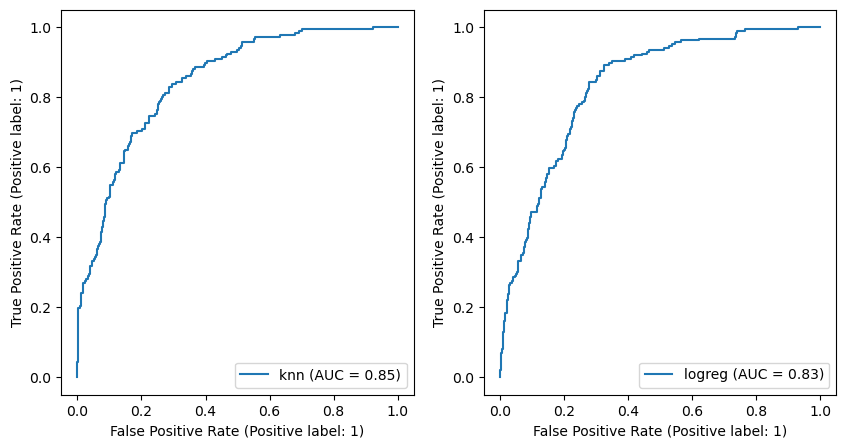

In [55]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
RocCurveDisplay.from_estimator(best_model_4, X_test, y_test, ax = ax, name = 'knn');
ax = plt.subplot(1, 2, 2)
RocCurveDisplay.from_estimator(best_model_5, X_test, y_test, ax = ax, name = 'logreg');

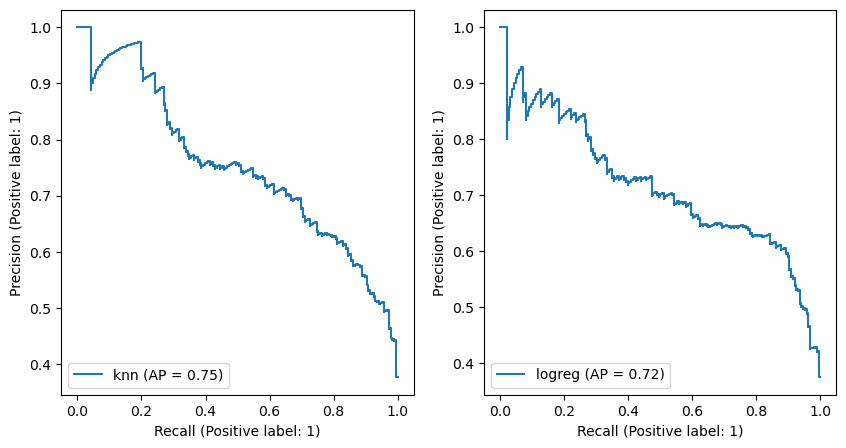

In [56]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
PrecisionRecallDisplay.from_estimator(best_model_4, X_test, y_test, ax = ax, name = 'knn');
ax = plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_estimator(best_model_5, X_test, y_test, ax = ax, name = 'logreg');

In [57]:
print(otvet1,otvet2,otvet3,otvet4,otvet5,otvet6)

0.8467094183184349 0.8318920844668998 0.8191151703588548 0.8454139137193937 0.8339810856328539 0.8235522736105714


0.8467094183184349 0.8318920844668998 0.8191151703588548 0.8454139137193937 0.833997279440342 0.8235522736105714

Попытка в дроп всех плохих фичей

In [58]:
df = pd.read_csv(path_train)
df['quality'] = np.where(df['quality'] > 6, 1, 0)
df = df.drop(columns = ['volatile acidity', 'chlorides', 'total sulfur dioxide', 'density'])
y = df.quality
X = df.drop(columns =['quality'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y, random_state=42)
pipe_6 = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('clf',           LogisticRegression())])

strat = StratifiedShuffleSplit(test_size = .3, train_size = .6, n_splits = 5, random_state = 42)
scaling = [ MinMaxScaler(), StandardScaler(),RobustScaler(), Normalizer()]

param_grid =[
    {'preprocessing': scaling,'clf__penalty': ['l2'], 
         'clf__solver': ['newton-cg' ,'lbfgs', 'liblinear', 'sag', 'saga'],
     'clf__C': [0.1, 0.5, 1.5, 3.0], 'clf__max_iter': [100, 300, 800]},
    {'preprocessing': scaling,'clf__penalty': ['l1'], 
         'clf__solver': ['liblinear'], 'clf__C': [0.1, 0.5, 1.5, 3.0], 'clf__max_iter': [100, 300, 800]},
    {'preprocessing': scaling,'clf__penalty': ['none'], 
         'clf__solver': ['lbfgs','newton-cg'], 'clf__max_iter': [100, 300, 800]}
    ]

grid_6 = GridSearchCV(pipe_6, param_grid, cv = strat, scoring='roc_auc', return_train_score = True)
grid_6.fit(X_train, y_train)   
grid_result_6 = pd.DataFrame(grid_6.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result_6

D:\bebeprogram\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\bebeprogram\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\bebeprogram\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\bebeprogram\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\bebeprogram\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\bebeprogram\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the nu

,253,257,261,236,184,204,224,196,180,200,...,15,19,35,55,11,31,51,243,247,251
mean_fit_time,0.008,0.007904,0.007975,0.011127,0.019778,0.018767,0.018742,0.011175,0.024115,0.02438,...,0.010387,0.012034,0.010921,0.010182,0.007221,0.007174,0.007197,0.00698,0.00678,0.006971
std_fit_time,0.000041,0.000354,0.000004,0.000283,0.001122,0.000963,0.001322,0.000396,0.001951,0.000953,...,0.000526,0.000705,0.000544,0.00042,0.000383,0.000404,0.000413,0.000027,0.000398,0.000036
mean_score_time,0.003996,0.004518,0.004182,0.004419,0.004765,0.00438,0.004788,0.004383,0.004988,0.005396,...,0.004615,0.005127,0.005171,0.005383,0.004589,0.004407,0.004855,0.003992,0.004181,0.004464
std_score_time,0.000009,0.000443,0.000405,0.000441,0.000392,0.00048,0.000747,0.000466,0.000002,0.0005,...,0.000457,0.000266,0.000958,0.001332,0.000484,0.000475,0.000455,0.000006,0.000403,0.000441
param_clf__C,0.5,0.5,0.5,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
param_clf__max_iter,100,300,800,800,100,300,800,100,100,300,...,100,100,300,800,100,300,800,100,300,800
param_clf__penalty,l1,l1,l1,l2,l2,l2,l2,l2,l2,l2,...,l2,l2,l2,l2,l2,l2,l2,l1,l1,l1
param_clf__solver,liblinear,liblinear,liblinear,saga,lbfgs,lbfgs,lbfgs,saga,newton-cg,newton-cg,...,sag,saga,sag,sag,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear
param_preprocessing,StandardScaler(),StandardScaler(),StandardScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),...,Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer()
params,"{'clf__C': 0.5, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.5, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.5, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 3.0, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 3.0, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 3.0, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 3.0, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 3.0, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 3.0, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 3.0, 'clf__max_iter': 300, 'clf__pe...",...,"{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe..."


In [59]:
print("Наилучшие параметры:\n{}\n".format(grid_6.best_params_))
print("Средняя правильность для наилучшей модели кроссвалидации на" 
      "валидационных тестовых наборах: {:.6f}\n".format(grid_6.best_score_)) 
print("Правильность для наилучшей модели на тестовом наборе: {:.6f}\n".format(grid_6.score(X_test, y_test)))
otvet5 = grid_6.score(X_test, y_test)
grid_result_6 = pd.DataFrame(grid_6.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result_6

Наилучшие параметры:
{'clf__C': 0.5, 'clf__max_iter': 100, 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'preprocessing': StandardScaler()}

Средняя правильность для наилучшей модели кроссвалидации навалидационных тестовых наборах: 0.788544

Правильность для наилучшей модели на тестовом наборе: 0.820718



,253,257,261,236,184,204,224,196,180,200,...,15,19,35,55,11,31,51,243,247,251
mean_fit_time,0.008,0.007904,0.007975,0.011127,0.019778,0.018767,0.018742,0.011175,0.024115,0.02438,...,0.010387,0.012034,0.010921,0.010182,0.007221,0.007174,0.007197,0.00698,0.00678,0.006971
std_fit_time,0.000041,0.000354,0.000004,0.000283,0.001122,0.000963,0.001322,0.000396,0.001951,0.000953,...,0.000526,0.000705,0.000544,0.00042,0.000383,0.000404,0.000413,0.000027,0.000398,0.000036
mean_score_time,0.003996,0.004518,0.004182,0.004419,0.004765,0.00438,0.004788,0.004383,0.004988,0.005396,...,0.004615,0.005127,0.005171,0.005383,0.004589,0.004407,0.004855,0.003992,0.004181,0.004464
std_score_time,0.000009,0.000443,0.000405,0.000441,0.000392,0.00048,0.000747,0.000466,0.000002,0.0005,...,0.000457,0.000266,0.000958,0.001332,0.000484,0.000475,0.000455,0.000006,0.000403,0.000441
param_clf__C,0.5,0.5,0.5,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
param_clf__max_iter,100,300,800,800,100,300,800,100,100,300,...,100,100,300,800,100,300,800,100,300,800
param_clf__penalty,l1,l1,l1,l2,l2,l2,l2,l2,l2,l2,...,l2,l2,l2,l2,l2,l2,l2,l1,l1,l1
param_clf__solver,liblinear,liblinear,liblinear,saga,lbfgs,lbfgs,lbfgs,saga,newton-cg,newton-cg,...,sag,saga,sag,sag,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear
param_preprocessing,StandardScaler(),StandardScaler(),StandardScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),...,Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer()
params,"{'clf__C': 0.5, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.5, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.5, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 3.0, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 3.0, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 3.0, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 3.0, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 3.0, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 3.0, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 3.0, 'clf__max_iter': 300, 'clf__pe...",...,"{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe..."


In [60]:
best_model_6 = grid_6.best_estimator_
print(classification_report(y_test, best_model_6.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       332
           1       0.67      0.57      0.61       186

    accuracy                           0.74       518
   macro avg       0.72      0.71      0.71       518
weighted avg       0.74      0.74      0.74       518



In [61]:
y_pred_7 = np.where(best_model_6.predict_proba(X_test)[:,1]>=0.42, 1, 0)
print(classification_report(y_test, y_pred_7))

              precision    recall  f1-score   support

           0       0.81      0.80      0.80       332
           1       0.65      0.68      0.66       186

    accuracy                           0.75       518
   macro avg       0.73      0.74      0.73       518
weighted avg       0.76      0.75      0.75       518



Попытка не увенчалась успехом, потеряли 1% в roc_auc и 4% в f1, а что в knn?

In [62]:
pipe_7 = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('regressor', KNeighborsClassifier())])

strat = StratifiedShuffleSplit(n_splits=5, test_size = 0.3, train_size = 0.6, random_state = 42)


p = [1,2]
weights = ['uniform','distance']
n_neighbors = np.arange(2,60)
scaling = [ MinMaxScaler(), StandardScaler(),RobustScaler(),Normalizer()]

param_grid =[
    {'preprocessing': scaling, 
     'regressor': [KNeighborsClassifier()],
         'regressor__n_neighbors': n_neighbors,
         'regressor__p': p,
         'regressor__weights': weights
     }]

grid_7 = GridSearchCV(pipe_7, param_grid, scoring='roc_auc' ,cv=strat,return_train_score=True)
grid_7.fit(X_train,y_train)
grid_7

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.3,
            train_size=0.6),
             estimator=Pipeline(steps=[('preprocessing', MinMaxScaler()),
                                       ('regressor', KNeighborsClassifier())]),
             param_grid=[{'preprocessing': [MinMaxScaler(), StandardScaler(),
                                            RobustScaler(), Normalizer()],
                          'regressor': [KNeighborsClassifier(n_neighbors=48,
                                                             p=1,
                                                             weights='distance')],
                          'regressor__n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59]),
                          'regressor__p':

In [63]:
print("Наилучшие параметры:\n{}\n".format(grid_7.best_params_))
print("Средняя правильность для наилучшей модели кроссвалидации на" 
      "валидационных тестовых наборах: {:.6f}\n".format(grid_7.best_score_)) 
print("Правильность для наилучшей модели на тестовом наборе: {:.6f}\n".format(grid_7.score(X_test, y_test)))
otvet5 = grid_7.score(X_test, y_test)
grid_result_7 = pd.DataFrame(grid_7.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result_7

Наилучшие параметры:
{'preprocessing': MinMaxScaler(), 'regressor': KNeighborsClassifier(n_neighbors=48, p=1, weights='distance'), 'regressor__n_neighbors': 48, 'regressor__p': 1, 'regressor__weights': 'distance'}

Средняя правильность для наилучшей модели кроссвалидации навалидационных тестовых наборах: 0.806530

Правильность для наилучшей модели на тестовом наборе: 0.841608



,185,209,229,197,201,213,189,205,221,217,...,704,701,706,703,700,702,697,696,699,698
mean_fit_time,0.007961,0.007988,0.008179,0.00797,0.008179,0.007807,0.007766,0.008125,0.00801,0.007985,...,0.007603,0.00777,0.007706,0.008022,0.007557,0.007421,0.007363,0.008446,0.007989,0.007619
std_fit_time,0.000625,0.000022,0.000736,0.000043,0.000373,0.000714,0.000393,0.000848,0.000085,0.000012,...,0.000511,0.000395,0.000734,0.000097,0.000494,0.000486,0.000468,0.001266,0.000021,0.000459
mean_score_time,0.022548,0.021765,0.022755,0.021984,0.021935,0.022678,0.021535,0.022938,0.02248,0.022563,...,0.008229,0.008182,0.008484,0.007999,0.008463,0.00839,0.008355,0.007292,0.008005,0.007931
std_score_time,0.001622,0.00034,0.000765,0.00117,0.000623,0.000496,0.00048,0.001567,0.000545,0.000789,...,0.000394,0.000392,0.00064,0.000019,0.000789,0.000479,0.000491,0.000434,0.000026,0.000059
param_preprocessing,MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),...,Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer()
param_regressor,"KNeighborsClassifier(n_neighbors=48, p=1, weig...","KNeighborsClassifier(n_neighbors=48, p=1, weig...","KNeighborsClassifier(n_neighbors=48, p=1, weig...","KNeighborsClassifier(n_neighbors=48, p=1, weig...","KNeighborsClassifier(n_neighbors=48, p=1, weig...","KNeighborsClassifier(n_neighbors=48, p=1, weig...","KNeighborsClassifier(n_neighbors=48, p=1, weig...","KNeighborsClassifier(n_neighbors=48, p=1, weig...","KNeighborsClassifier(n_neighbors=48, p=1, weig...","KNeighborsClassifier(n_neighbors=48, p=1, weig...",...,"KNeighborsClassifier(n_neighbors=48, p=1, weig...","KNeighborsClassifier(n_neighbors=48, p=1, weig...","KNeighborsClassifier(n_neighbors=48, p=1, weig...","KNeighborsClassifier(n_neighbors=48, p=1, weig...","KNeighborsClassifier(n_neighbors=48, p=1, weig...","KNeighborsClassifier(n_neighbors=48, p=1, weig...","KNeighborsClassifier(n_neighbors=48, p=1, weig...","KNeighborsClassifier(n_neighbors=48, p=1, weig...","KNeighborsClassifier(n_neighbors=48, p=1, weig...","KNeighborsClassifier(n_neighbors=48, p=1, weig..."
param_regressor__n_neighbors,48,54,59,51,52,55,49,53,57,56,...,4,3,4,3,3,3,2,2,2,2
param_regressor__p,1,1,1,1,1,1,1,1,1,1,...,1,1,2,2,1,2,1,1,2,2
param_regressor__weights,distance,distance,distance,distance,distance,distance,distance,distance,distance,distance,...,uniform,distance,uniform,distance,uniform,uniform,distance,uniform,distance,uniform
params,"{'preprocessing': MinMaxScaler(), 'regressor':...","{'preprocessing': MinMaxScaler(), 'regressor':...","{'preprocessing': MinMaxScaler(), 'regressor':...","{'preprocessing': MinMaxScaler(), 'regressor':...","{'preprocessing': MinMaxScaler(), 'regressor':...","{'preprocessing': MinMaxScaler(), 'regressor':...","{'preprocessing': MinMaxScaler(), 'regressor':...","{'preprocessing': MinMaxScaler(), 'regressor':...","{'preprocessing': MinMaxScaler(), 'regressor':...","{'preprocessing': MinMaxScaler(), 'regressor':...",...,"{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K..."


In [64]:
best_model_7 = grid_7.best_estimator_
print(classification_report(y_test, best_model_7.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       332
           1       0.69      0.65      0.67       186

    accuracy                           0.77       518
   macro avg       0.75      0.74      0.74       518
weighted avg       0.77      0.77      0.77       518



In [65]:
y_pred_7 = np.where(best_model_7.predict_proba(X_test)[:,1]>=0.49, 1, 0)
print(classification_report(y_test, y_pred_7))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       332
           1       0.68      0.66      0.67       186

    accuracy                           0.77       518
   macro avg       0.75      0.74      0.75       518
weighted avg       0.77      0.77      0.77       518



**Выводы** 

Scoring - roc_aug

Порог - не меняем, по 0.7 в f1, recall, precision - самое большое

Модель - knn

Параметры - Наилучшие параметры:
{'preprocessing': RobustScaler(), 'regressor': KNeighborsClassifier(n_neighbors=58, p=1, weights='distance'), 'regressor__n_neighbors': 58, 'regressor__p': 1, 'regressor__weights': 'distance'}

Фичи: ниче не трогаем, иначе все станет только хуже

Появилась идея - удалить фичи я попробовал, а вот добавлять нет
в книжке из гита по введению в мл, пишут что можно попробовать добавить любые линейные преобразования, возведение в степень
ну, так и сделал

In [66]:
df = pd.read_csv(path_train)
df['quality'] = np.where(df['quality'] > 6, 1, 0)
#df = df.drop(columns = ['volatile acidity', 'chlorides', 'total sulfur dioxide', 'density'])
#df['feach1'] = df['alcohol']**2
#df['feach2'] = df['fixed acidity']**2
#df['feach3'] = df['sulphates']**2
#df['feach4'] = df['total sulfur dioxide']**2
#df['feach5'] = df['free sulfur dioxide']**2
#df['feach6'] = df['chlorides']**2
#df['feach7'] = df['residual sugar']**2
#df['feach8'] = df['citric acid']**2
#df['feach9'] = df['alcohol']**2
#df['feach10'] = df['fixed acidity']*2
#df['feach11'] = df['sulphates']*2
#df['feach12'] = df['total sulfur dioxide']*2
#df['feach13'] = df['free sulfur dioxide']*2
#df['feach14'] = df['chlorides']*2
#df['feach15'] = df['residual sugar']*2
#df['feach16'] = df['citric acid']*2


df['total acidity'] = df['fixed acidity'] + df['volatile acidity']
df['mega total acidity'] = df['fixed acidity'] + df['volatile acidity']+ df ['citric acid']
df['sulphates/fixed acidity volatile'] = df['sulphates']/df['fixed acidity']
df['сумма хим примесей'] = df['fixed acidity'] + df['volatile acidity']+df['citric acid'] + df['residual sugar'] +df['chlorides'] + df['free sulfur dioxide']+df['total sulfur dioxide'] + df['sulphates']
#df['chlorides/mega total acidity'] = df['sulphates']/df['mega total acidity']

закомменченные фичи - плохие. Код я снес, но они ухудшали модель.
С другой стороны суммы хорошо прокачали, 85 по roc auc, и потеряли 1 % в recall - приятно

In [67]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,total acidity,mega total acidity,sulphates/fixed acidity volatile,сумма хим примесей
0,6.4,0.17,0.34,1.5,0.091,42.0,135.0,0.99380,3.25,0.49,9.6,1,6.57,6.91,0.076562,185.991
1,8.0,0.42,0.36,5.0,0.037,34.0,101.0,0.99200,3.13,0.57,12.3,1,8.42,8.78,0.071250,149.387
2,6.7,0.27,0.25,8.0,0.053,54.0,202.0,0.99610,3.22,0.43,9.3,0,6.97,7.22,0.064179,271.703
3,5.2,0.21,0.31,1.7,0.048,17.0,61.0,0.98953,3.24,0.37,12.0,1,5.41,5.72,0.071154,85.838
4,7.6,0.48,0.37,1.2,0.034,5.0,57.0,0.99256,3.05,0.54,10.4,0,8.08,8.45,0.071053,72.224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1720,6.9,0.39,0.22,4.3,0.030,10.0,102.0,0.99300,3.00,0.87,11.6,0,7.29,7.51,0.126087,124.710
1721,6.4,0.34,0.10,1.1,0.048,19.0,84.0,0.99270,3.21,0.38,9.8,0,6.74,6.84,0.059375,111.368
1722,7.0,0.53,0.43,6.1,0.029,6.0,76.0,0.99118,3.08,0.50,12.5,1,7.53,7.96,0.071429,96.589
1723,5.9,0.17,0.29,3.1,0.030,32.0,123.0,0.98913,3.41,0.33,13.7,1,6.07,6.36,0.055932,164.820


In [68]:
y = df.quality
X = df.drop(columns =['quality'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y, random_state=42)

pipe_4 = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('regressor', KNeighborsClassifier())])

strat = StratifiedShuffleSplit(n_splits=5, test_size = 0.3, train_size = 0.6, random_state = 42)


p = [1,2]
weights = ['uniform','distance']
n_neighbors = np.arange(2,60)
scaling = [ MinMaxScaler(), StandardScaler(),RobustScaler(),Normalizer()]

param_grid =[
    {'preprocessing': scaling, 
     'regressor': [KNeighborsClassifier()],
         'regressor__n_neighbors': n_neighbors,
         'regressor__p': p,
         'regressor__weights': weights
     }]

grid_4 = GridSearchCV(pipe_4, param_grid, scoring='roc_auc' ,cv=strat,return_train_score=True)
grid_4.fit(X_train,y_train)
grid_4

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.3,
            train_size=0.6),
             estimator=Pipeline(steps=[('preprocessing', MinMaxScaler()),
                                       ('regressor', KNeighborsClassifier())]),
             param_grid=[{'preprocessing': [MinMaxScaler(), StandardScaler(),
                                            RobustScaler(), Normalizer()],
                          'regressor': [KNeighborsClassifier(n_neighbors=29,
                                                             weights='distance')],
                          'regressor__n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59]),
                          'regressor__p': [1, 2],
                          'regressor__weights': ['uniform

In [69]:
print("Наилучшие параметры:\n{}\n".format(grid_4.best_params_))
print("Средняя правильность для наилучшей модели кроссвалидации на" 
      "валидационных тестовых наборах: {:.6f}\n".format(grid_4.best_score_)) 
print("Правильность для наилучшей модели на тестовом наборе: {:.6f}\n".format(grid_4.score(X_test, y_test)))
otvet5 = grid_4.score(X_test, y_test)
grid_result_4 = pd.DataFrame(grid_4.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result_4

Наилучшие параметры:
{'preprocessing': StandardScaler(), 'regressor': KNeighborsClassifier(n_neighbors=29, weights='distance'), 'regressor__n_neighbors': 29, 'regressor__p': 2, 'regressor__weights': 'distance'}

Средняя правильность для наилучшей модели кроссвалидации навалидационных тестовых наборах: 0.814024

Правильность для наилучшей модели на тестовом наборе: 0.850515



,343,339,347,567,335,607,599,611,331,575,...,712,702,708,701,704,699,700,698,697,696
mean_fit_time,0.010278,0.010429,0.010576,0.014928,0.010382,0.014948,0.01508,0.014781,0.010363,0.015157,...,0.009578,0.00977,0.0095,0.009716,0.009614,0.010193,0.00956,0.010069,0.009768,0.009793
std_fit_time,0.00041,0.00054,0.000488,0.000614,0.000499,0.000646,0.00046,0.000384,0.000497,0.000398,...,0.000484,0.000414,0.000468,0.000448,0.000529,0.000963,0.000474,0.000157,0.000387,0.000402
mean_score_time,0.026447,0.02697,0.027135,0.027137,0.026335,0.027552,0.027133,0.028291,0.027127,0.02644,...,0.012553,0.011259,0.012365,0.012323,0.012713,0.010516,0.011407,0.010086,0.011162,0.010771
std_score_time,0.000453,0.000519,0.000401,0.002467,0.000499,0.000494,0.000373,0.000815,0.001171,0.001008,...,0.000477,0.000379,0.00047,0.001514,0.001204,0.000467,0.000546,0.00047,0.000381,0.000399
param_preprocessing,StandardScaler(),StandardScaler(),StandardScaler(),RobustScaler(),StandardScaler(),RobustScaler(),RobustScaler(),RobustScaler(),StandardScaler(),RobustScaler(),...,Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer()
param_regressor,"KNeighborsClassifier(n_neighbors=29, weights='...","KNeighborsClassifier(n_neighbors=29, weights='...","KNeighborsClassifier(n_neighbors=29, weights='...","KNeighborsClassifier(n_neighbors=29, weights='...","KNeighborsClassifier(n_neighbors=29, weights='...","KNeighborsClassifier(n_neighbors=29, weights='...","KNeighborsClassifier(n_neighbors=29, weights='...","KNeighborsClassifier(n_neighbors=29, weights='...","KNeighborsClassifier(n_neighbors=29, weights='...","KNeighborsClassifier(n_neighbors=29, weights='...",...,"KNeighborsClassifier(n_neighbors=29, weights='...","KNeighborsClassifier(n_neighbors=29, weights='...","KNeighborsClassifier(n_neighbors=29, weights='...","KNeighborsClassifier(n_neighbors=29, weights='...","KNeighborsClassifier(n_neighbors=29, weights='...","KNeighborsClassifier(n_neighbors=29, weights='...","KNeighborsClassifier(n_neighbors=29, weights='...","KNeighborsClassifier(n_neighbors=29, weights='...","KNeighborsClassifier(n_neighbors=29, weights='...","KNeighborsClassifier(n_neighbors=29, weights='..."
param_regressor__n_neighbors,29,28,30,27,27,37,35,38,26,29,...,6,3,5,3,4,2,3,2,2,2
param_regressor__p,2,2,2,2,2,2,2,2,2,2,...,1,2,1,1,1,2,1,2,1,1
param_regressor__weights,distance,distance,distance,distance,distance,distance,distance,distance,distance,distance,...,uniform,uniform,uniform,distance,uniform,distance,uniform,uniform,distance,uniform
params,"{'preprocessing': StandardScaler(), 'regressor...","{'preprocessing': StandardScaler(), 'regressor...","{'preprocessing': StandardScaler(), 'regressor...","{'preprocessing': RobustScaler(), 'regressor':...","{'preprocessing': StandardScaler(), 'regressor...","{'preprocessing': RobustScaler(), 'regressor':...","{'preprocessing': RobustScaler(), 'regressor':...","{'preprocessing': RobustScaler(), 'regressor':...","{'preprocessing': StandardScaler(), 'regressor...","{'preprocessing': RobustScaler(), 'regressor':...",...,"{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K...","{'preprocessing': Normalizer(), 'regressor': K..."


In [70]:
best_model_4 = grid_4.best_estimator_
print(classification_report(y_test, best_model_4.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       332
           1       0.69      0.69      0.69       186

    accuracy                           0.78       518
   macro avg       0.76      0.76      0.76       518
weighted avg       0.78      0.78      0.78       518



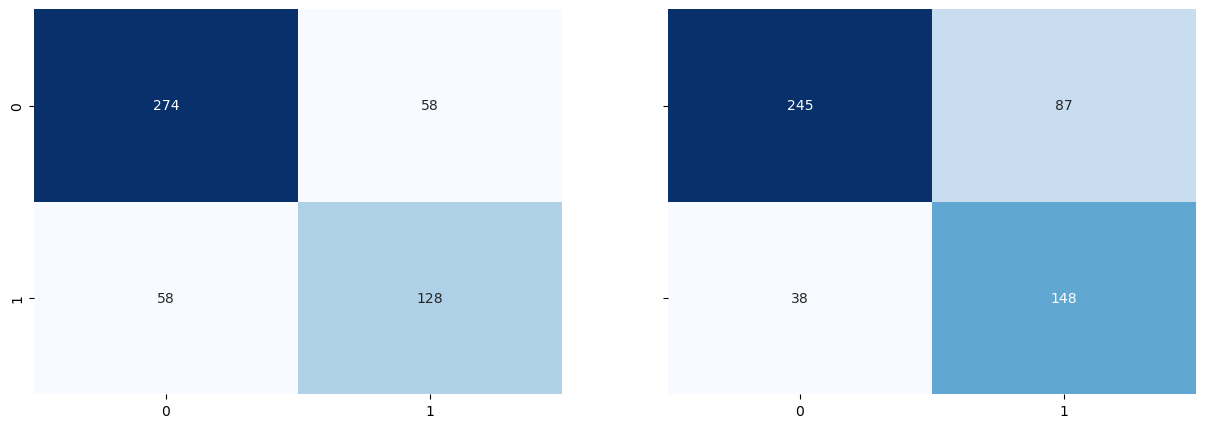

In [71]:
matrix_1=confusion_matrix(y_test,best_model_4.predict(X_test))
matrix_2=confusion_matrix(y_test,y_pred_4)
fig,ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,5))
ax = plt.subplot(1, 2, 1)
sns.heatmap(matrix_1,annot=True, fmt='g', cbar=None,cmap="Blues");
ax = plt.subplot(1, 2, 2)
sns.heatmap(matrix_2,annot=True, fmt='g', cbar=None,cmap="Blues");

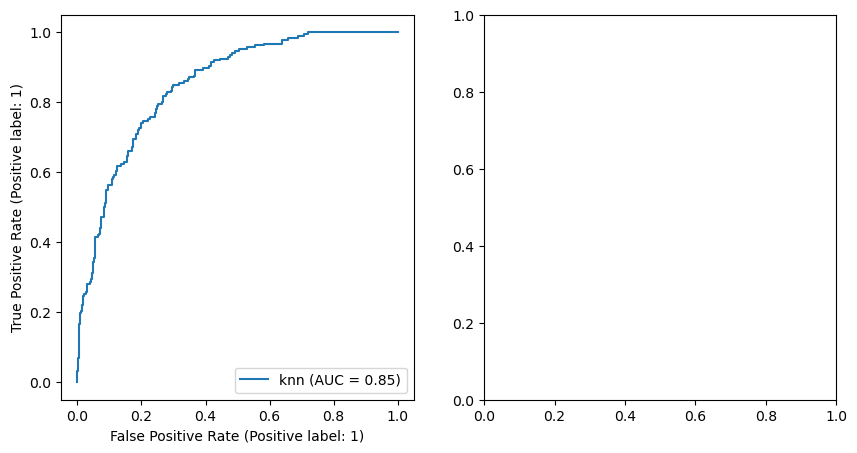

In [72]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
RocCurveDisplay.from_estimator(best_model_4, X_test, y_test, ax = ax, name = 'knn');

In [73]:
y_pred_4 = np.where(best_model_4.predict_proba(X_test)[:,1]>=0.49, 1, 0)
print(classification_report(y_test, y_pred_4))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82       332
           1       0.68      0.70      0.69       186

    accuracy                           0.77       518
   macro avg       0.75      0.76      0.76       518
weighted avg       0.78      0.77      0.77       518



5 линейных фичей - 0.840
4 линейных фичей -  0.8505
3 линейных фичей - 0.848021
2 линейных фичей - 0.8499

In [74]:
pipe_6 = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('clf',           LogisticRegression())])

strat = StratifiedShuffleSplit(test_size = .3, train_size = .6, n_splits = 5, random_state = 42)
scaling = [ MinMaxScaler(), StandardScaler(),RobustScaler(), Normalizer()]

param_grid =[
    {'preprocessing': scaling,'clf__penalty': ['l2'], 
         'clf__solver': ['newton-cg' ,'lbfgs', 'liblinear', 'sag', 'saga'], 
     'clf__C': [0.1, 0.5, 1.5, 3.0], 'clf__max_iter': [100, 300, 800]},
    {'preprocessing': scaling,'clf__penalty': ['l1'], 
         'clf__solver': ['liblinear'], 'clf__C': [0.1, 0.5, 1.5, 3.0], 'clf__max_iter': [100, 300, 800]},
    {'preprocessing': scaling,'clf__penalty': ['none'], 
         'clf__solver': ['lbfgs','newton-cg'], 'clf__max_iter': [100, 300, 800]}
    ]

grid_6 = GridSearchCV(pipe_6, param_grid, cv = strat, scoring='roc_auc', return_train_score = True)
grid_6.fit(X_train, y_train)   
grid_result_6 = pd.DataFrame(grid_6.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result_6

D:\bebeprogram\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\bebeprogram\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\bebeprogram\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\bebeprogram\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\bebeprogram\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\bebeprogram\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warning

D:\bebeprogram\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\bebeprogram\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\bebeprogram\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\bebeprogram\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\bebeprogram\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\bebeprogram\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warning

D:\bebeprogram\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,77,61,81,101,97,117,65,85,105,73,...,39,11,31,51,255,263,259,243,247,251
mean_fit_time,0.042206,0.027097,0.028819,0.028525,0.04731,0.046193,0.023215,0.023561,0.023782,0.026084,...,0.013852,0.007907,0.007404,0.007978,0.008979,0.008752,0.009741,0.006553,0.007057,0.007389
std_fit_time,0.002162,0.002358,0.002474,0.002032,0.006108,0.006823,0.001715,0.001525,0.001934,0.003566,...,0.000212,0.000962,0.000807,0.000613,0.000643,0.000718,0.0004,0.000472,0.000502,0.000467
mean_score_time,0.005826,0.005416,0.005137,0.005178,0.004581,0.004815,0.005049,0.005187,0.004947,0.004178,...,0.004776,0.003591,0.004191,0.004405,0.004724,0.004573,0.004584,0.004816,0.004564,0.004426
std_score_time,0.001461,0.000796,0.00041,0.000737,0.000432,0.000417,0.000594,0.000424,0.000603,0.000393,...,0.000412,0.000784,0.000403,0.000492,0.0004,0.000535,0.000484,0.00042,0.000512,0.000438
param_clf__C,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.1,0.1,0.1,0.1,0.5,0.5,0.5,0.1,0.1,0.1
param_clf__max_iter,100,100,300,800,300,800,100,300,800,100,...,300,100,300,800,100,800,300,100,300,800
param_clf__penalty,l2,l2,l2,l2,l2,l2,l2,l2,l2,l2,...,l2,l2,l2,l2,l1,l1,l1,l1,l1,l1
param_clf__solver,saga,newton-cg,newton-cg,newton-cg,saga,saga,lbfgs,lbfgs,lbfgs,sag,...,saga,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear
param_preprocessing,StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),...,Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer()
params,"{'clf__C': 0.5, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.5, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.5, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.5, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.5, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.5, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.5, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.5, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.5, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.5, 'clf__max_iter': 100, 'clf__pe...",...,"{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.5, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.5, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.5, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe..."


In [75]:
print("Наилучшие параметры:\n{}\n".format(grid_6.best_params_))
print("Средняя правильность для наилучшей модели кроссвалидации на" 
      "валидационных тестовых наборах: {:.6f}\n".format(grid_6.best_score_)) 
print("Правильность для наилучшей модели на тестовом наборе: {:.6f}\n".format(grid_6.score(X_test, y_test)))
otvet5 = grid_6.score(X_test, y_test)
grid_result_6 = pd.DataFrame(grid_6.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result_6

Наилучшие параметры:
{'clf__C': 0.5, 'clf__max_iter': 100, 'clf__penalty': 'l2', 'clf__solver': 'saga', 'preprocessing': StandardScaler()}

Средняя правильность для наилучшей модели кроссвалидации навалидационных тестовых наборах: 0.817537

Правильность для наилучшей модели на тестовом наборе: 0.833673



,77,61,81,101,97,117,65,85,105,73,...,39,11,31,51,255,263,259,243,247,251
mean_fit_time,0.042206,0.027097,0.028819,0.028525,0.04731,0.046193,0.023215,0.023561,0.023782,0.026084,...,0.013852,0.007907,0.007404,0.007978,0.008979,0.008752,0.009741,0.006553,0.007057,0.007389
std_fit_time,0.002162,0.002358,0.002474,0.002032,0.006108,0.006823,0.001715,0.001525,0.001934,0.003566,...,0.000212,0.000962,0.000807,0.000613,0.000643,0.000718,0.0004,0.000472,0.000502,0.000467
mean_score_time,0.005826,0.005416,0.005137,0.005178,0.004581,0.004815,0.005049,0.005187,0.004947,0.004178,...,0.004776,0.003591,0.004191,0.004405,0.004724,0.004573,0.004584,0.004816,0.004564,0.004426
std_score_time,0.001461,0.000796,0.00041,0.000737,0.000432,0.000417,0.000594,0.000424,0.000603,0.000393,...,0.000412,0.000784,0.000403,0.000492,0.0004,0.000535,0.000484,0.00042,0.000512,0.000438
param_clf__C,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.1,0.1,0.1,0.1,0.5,0.5,0.5,0.1,0.1,0.1
param_clf__max_iter,100,100,300,800,300,800,100,300,800,100,...,300,100,300,800,100,800,300,100,300,800
param_clf__penalty,l2,l2,l2,l2,l2,l2,l2,l2,l2,l2,...,l2,l2,l2,l2,l1,l1,l1,l1,l1,l1
param_clf__solver,saga,newton-cg,newton-cg,newton-cg,saga,saga,lbfgs,lbfgs,lbfgs,sag,...,saga,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear
param_preprocessing,StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),...,Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer()
params,"{'clf__C': 0.5, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.5, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.5, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.5, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.5, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.5, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.5, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.5, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.5, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.5, 'clf__max_iter': 100, 'clf__pe...",...,"{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.5, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.5, 'clf__max_iter': 800, 'clf__pe...","{'clf__C': 0.5, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 100, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 300, 'clf__pe...","{'clf__C': 0.1, 'clf__max_iter': 800, 'clf__pe..."


In [76]:
best_model_6 = grid_6.best_estimator_
print(classification_report(y_test, best_model_6.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       332
           1       0.66      0.63      0.65       186

    accuracy                           0.75       518
   macro avg       0.73      0.73      0.73       518
weighted avg       0.75      0.75      0.75       518



In [77]:
best_model = best_model_6.named_steps['clf']
importance = best_model.coef_[0]

for i, val in enumerate(importance):
    print('Фича %d: %.5f' % (i, val))

Фича 0: 0.12155
Фича 1: -0.40758
Фича 2: -0.02330
Фича 3: 0.78978
Фича 4: -0.34540
Фича 5: 0.38215
Фича 6: -0.28398
Фича 7: -1.10686
Фича 8: 0.53538
Фича 9: 0.46404
Фича 10: 0.58370
Фича 11: 0.06926
Фича 12: 0.06273
Фича 13: -0.33345
Фича 14: -0.03162


По моделям ничего не изменилось, knn в легкую бьет рекорды, logreg я так и не смог дотянуть доо первого,
баеса оставил в покое данные неплохо так коррелируют, так что за наивность наказывают низким скором

**мега выводы**

Scoring - roc_aug

Порог - не меняем, сохраням баланс по метрикам, потому что не знаем конкретную бизнес задачу

Модель - knn 

Параметры - Наилучшие параметры:
{'preprocessing': StandardScaler(), 'regressor': KNeighborsClassifier(n_neighbors=29, weights='distance'), 'regressor__n_neighbors': 29, 'regressor__p': 2, 'regressor__weights': 'distance'}

Фичи: ниче не удаляем, добавляем 
df['total acidity'] = df['fixed acidity'] + df['volatile acidity']
df['mega total acidity'] = df['fixed acidity'] + df['volatile acidity']+ df ['citric acid']
df['sulphates/fixed acidity volatile'] = df['sulphates']/df['fixed acidity']
df['сумма хим примесей'] = df['fixed acidity'] + df['volatile acidity']+df['citric acid'] + df['residual sugar'] +df['chlorides'] + df['free sulfur dioxide']+df['total sulfur dioxide'] + df['sulphates']
и получаем заслуженные 85 по roc auc